<a href="https://colab.research.google.com/github/buthaina279/P4DS/blob/main/COMP5623M_CW1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COMP5623M Assessment Coursework 1 - Image Classification [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Practice building, evaluating, and finetuning a convolutional neural network on an image dataset from development to testing. 
> 2. Gain a deeper understanding of feature maps and filters by visualizing some from a pre-trained network. 


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process, especially for Question 1.3. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the ImageNet dataset [https://image-net.org/]. Our subset of Tiny ImageNet contains 30 different categories, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Private class Kaggle competition and data](https://www.kaggle.com/t/9b703e0d71824a658e186d5f69960e27)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard.

### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):


ml20baya

Your full name:

Buthaina Abdullah Alshareef

## Imports

Feel free to add to this section as needed.

You may need to download `cv2` using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [5]:
import cv2
import math

import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url


import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms,utils
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchsummary import summary
import torchvision
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

## QUESTION 1 [55 marks]

One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**
*   **1.1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.1.2** PyTorch ```Model``` class for simple CNN model
*   **1.1.3** Overfitting on a single batch
*   **1.2.1** Training on complete dataset
*   **1.2.2** Fine-tuning model
*   **1.2.3** Generating confusion matrices
*   **1.3**   Testing on test set on Kaggle


## 1.1 Single-batch training [14 marks]

We will use a method of development called “single-batch training”, or "overfitting a single batch", in which we check that our model and the training code is working properly and can overfit a single training batch (i.e., we can drive the training loss to zero). Then we move on to training on the complete training set and adjust for any overfitting and fine-tune the model via regularisation.

### 1.1.1 Dataset class [3 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

Tesla P100-PCIE-16GB
1


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
ROOT_DIR = "/content/drive/MyDrive/comp5623m-2022/train_set/train_set/"
ROOT = "/content/drive/MyDrive/comp5623m-2022/"
mapping_img30 = "/content/drive/MyDrive/comp5623m-2022/mapping.txt"


In [ ]:
#!unzip "/content/drive/MyDrive/comp5623m-2022_z.zip" -d "/content"

In [9]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CLASS_LABELS = ["baboon",
                "banana"
                ,"bee"
                ,"bison"
                ,"butterfly"
                ,"candle"
                ,"cardigan"
                ,"chihuahua"
                ,"elephant"
                ,"espresso"
                ,"fly"
                ,"goldfish"
                ,"goose"
                ,"grasshopper"
                ,"hourglass"
                ,"icecream"
                ,"ipod"
                ,"jellyfish"
                ,"koala"
                ,"ladybug"
                ,"lion"
                ,"mushroom"
                ,"penguin"
                ,"pig"
                ,"pizza"
                ,"pretzel"
                ,"redpanda"
                ,"refrigerator"
                ,"sombrero"
                ,"umbrella"]



mean =  [0.4828, 0.4419, 0.3691]
std = [0.2130, 0.2060, 0.2022]

class TinyImageNet30(Dataset):
    def __init__(self, df, transform = None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_x = Image.open(self.df['path'][index])
        
        try:
            img_x = img_x.convert('RGB')
            
        except:
            pass
        
        img_y = torch.tensor(int(self.df['class'][index]))
        
        if self.transform:
            img_x = self.transform(img_x)
        return img_x,img_y
        

paths, classes = [], []
for i, dir_ in enumerate(CLASS_LABELS):
    for entry in os.scandir(ROOT_DIR + dir_):
        if (entry.is_file()):
            paths.append(entry.path)
            classes.append(i)
            
data = {'path': paths,'class': classes}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True)


print("Found", len(data_df), "images.")
print(data_df.head())

trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Split the data into train and test sets
train_split = 0.80 
train_size = int(len(data_df)*train_split)


train_dataset = TinyImageNet30(
    df=data_df[:train_size],
    transform=trnsfrm,
)

valid_dataset = TinyImageNet30(
    df=data_df[train_size:].reset_index(drop=True),
    transform=trnsfrm,
)

train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True,num_workers=6)

valid_loader = DataLoader(valid_dataset, batch_size=64,shuffle=True,num_workers=6)


print("dataset_train length", len(train_dataset))
print("dataset_valid length", len(valid_dataset))
print("train_loader length", len(train_loader))
print("valid_loader length", len(valid_loader))



Found 13500 images.
                                                path  class
0  /content/drive/MyDrive/comp5623m-2022/train_se...      7
1  /content/drive/MyDrive/comp5623m-2022/train_se...      0
2  /content/drive/MyDrive/comp5623m-2022/train_se...     24
3  /content/drive/MyDrive/comp5623m-2022/train_se...     21
4  /content/drive/MyDrive/comp5623m-2022/train_se...     13
dataset_train length 10800
dataset_valid length 2700
train_loader length 169
valid_loader length 43


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 64, 64])


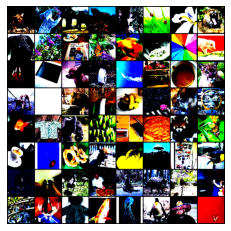

20 18 8 20 18 19 19 20 8 4 16 4 11 2 29 23 5 16 7 22 17 27 9 20 7 15 20 21 1 29 20 14 11 6 8 1 16 24 26 4 9 17 25 7 10 8 27 22 5 28 12 24 0 23 0 17 19 15 6 11 17 22 28 14


In [10]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.axis('off')
    plt.show()
    return xa
    
# single batch
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.size())

#disply images
timshow(utils.make_grid(images))
print(*labels.numpy())     # * unpack the ndarray

### 1.1.2 Define a CNN model [3 marks]

Create a new model class using a combination of convolutional and fully connected layers, ReLU, and max-pool. 

In [200]:
class model112(nn.Module):
  def __init__(self):
    super(model112, self).__init__()

    self.conv1 = nn.Conv2d(3, 87, kernel_size= 5)
    self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(87, 120, kernel_size= 3)
    self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
    self.fcl1 = nn.Linear(14*14*120, 1500)

    self.fcl2 = nn.Linear(1500, 30)
        
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.mp1(x)

    x = F.relu(self.conv2(x))
    x = self.mp2(x)

    x = x.reshape(-1, 14*14*120)

    x = self.fcl1(x)
    x = F.relu(x)

    x = self.fcl2(x)
    return x
model122 = model112()
model112 = nn.DataParallel(model122)
model112 = model112.to(device)
summary(model112.to(device), input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 87, 60, 60]           6,612
         MaxPool2d-2           [-1, 87, 30, 30]               0
            Conv2d-3          [-1, 120, 28, 28]          94,080
         MaxPool2d-4          [-1, 120, 14, 14]               0
            Linear-5                 [-1, 1500]      35,281,500
            Linear-6                   [-1, 30]          45,030
          model112-7                   [-1, 30]               0
Total params: 35,427,222
Trainable params: 35,427,222
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.90
Params size (MB): 135.14
Estimated Total Size (MB): 139.09
----------------------------------------------------------------


### 1.1.3 Single-batch training [8 marks]

Write the foundational code which trains your network given **one single batch** of training data and computes the loss on the complete validation set for each epoch. Set ```batch_size = 64```. 

Display the graph of the training and validation loss over training epochs, showing as long as necessary to show you can drive the training loss to zero.

> Please leave all graphs and code you would like to be marked clearly displayed without needing to run code cells or wait for training.


In [116]:
#validation for all models
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    # net = net.to(device)
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net(images)
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            
    return running_loss/n, correct/total 

In [130]:
#Run single batch
nepochs = 50
results_path = ROOT+'results/singlebatch50epochsClass.pt'

statsrec = np.zeros((4,nepochs))

data = next(iter(train_loader))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model112.parameters(), lr=0.01, momentum=0.9)

for epoch in tqdm(range(nepochs)):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    
    # get a batch of random training examples (images and corresponding labels)
    
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
        
         # Zero the parameter gradients
    optimizer.zero_grad()

        # Forward, backward, and update parameters
    outputs = model112(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    
        # accumulate loss
    running_loss += loss.item()
    n += 1
        
        # accumulate data for accuracy
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)    # add in the number of labels in this minibatch
    correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(valid_loader, model112)
    statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validation loss: {ltst: .3f} validation accuracy: {atst: .1%}")

# save network parameters, losses and accuracy
torch.save({"state_dict": model112.state_dict(), "stats": statsrec}, results_path)

# save network parameters and losses
#torch.save({"state_dict": net.state_dict(), "losses": losses}, results_path)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  2%|▏         | 1/50 [00:03<02:48,  3.44s/it]

epoch: 0 training loss:  3.389 training accuracy:  3.1%  validation loss:  3.400 validation accuracy:  4.0%


  4%|▍         | 2/50 [00:06<02:46,  3.47s/it]

epoch: 1 training loss:  3.337 training accuracy:  9.4%  validation loss:  3.406 validation accuracy:  3.7%


  6%|▌         | 3/50 [00:10<02:42,  3.46s/it]

epoch: 2 training loss:  3.249 training accuracy:  10.9%  validation loss:  3.420 validation accuracy:  3.7%


  8%|▊         | 4/50 [00:13<02:39,  3.47s/it]

epoch: 3 training loss:  3.142 training accuracy:  9.4%  validation loss:  3.458 validation accuracy:  3.7%


 10%|█         | 5/50 [00:17<02:35,  3.46s/it]

epoch: 4 training loss:  3.022 training accuracy:  9.4%  validation loss:  3.529 validation accuracy:  3.7%


 12%|█▏        | 6/50 [00:20<02:30,  3.43s/it]

epoch: 5 training loss:  2.889 training accuracy:  9.4%  validation loss:  3.637 validation accuracy:  3.7%


 14%|█▍        | 7/50 [00:24<02:28,  3.46s/it]

epoch: 6 training loss:  2.737 training accuracy:  14.1%  validation loss:  3.748 validation accuracy:  4.0%


 16%|█▌        | 8/50 [00:27<02:24,  3.44s/it]

epoch: 7 training loss:  2.540 training accuracy:  26.6%  validation loss:  3.879 validation accuracy:  4.6%


 18%|█▊        | 9/50 [00:31<02:21,  3.45s/it]

epoch: 8 training loss:  2.294 training accuracy:  59.4%  validation loss:  4.009 validation accuracy:  6.1%


 20%|██        | 10/50 [00:34<02:18,  3.46s/it]

epoch: 9 training loss:  2.009 training accuracy:  68.8%  validation loss:  4.162 validation accuracy:  6.3%


 22%|██▏       | 11/50 [00:37<02:14,  3.45s/it]

epoch: 10 training loss:  1.650 training accuracy:  73.4%  validation loss:  4.339 validation accuracy:  6.0%


 24%|██▍       | 12/50 [00:41<02:10,  3.44s/it]

epoch: 11 training loss:  1.254 training accuracy:  78.1%  validation loss:  4.599 validation accuracy:  5.7%


 26%|██▌       | 13/50 [00:45<02:12,  3.59s/it]

epoch: 12 training loss:  0.887 training accuracy:  89.1%  validation loss:  4.968 validation accuracy:  5.1%


 28%|██▊       | 14/50 [00:48<02:07,  3.55s/it]

epoch: 13 training loss:  0.576 training accuracy:  96.9%  validation loss:  5.610 validation accuracy:  5.7%


 30%|███       | 15/50 [00:52<02:03,  3.51s/it]

epoch: 14 training loss:  0.346 training accuracy:  98.4%  validation loss:  6.549 validation accuracy:  5.6%


 32%|███▏      | 16/50 [00:56<02:04,  3.68s/it]

epoch: 15 training loss:  0.180 training accuracy:  98.4%  validation loss:  7.752 validation accuracy:  5.9%


 34%|███▍      | 17/50 [00:59<02:00,  3.64s/it]

epoch: 16 training loss:  0.092 training accuracy:  100.0%  validation loss:  9.027 validation accuracy:  6.0%


 36%|███▌      | 18/50 [01:03<01:55,  3.60s/it]

epoch: 17 training loss:  0.044 training accuracy:  100.0%  validation loss:  10.401 validation accuracy:  5.4%


 38%|███▊      | 19/50 [01:06<01:51,  3.58s/it]

epoch: 18 training loss:  0.016 training accuracy:  100.0%  validation loss:  11.655 validation accuracy:  5.0%


 40%|████      | 20/50 [01:10<01:47,  3.58s/it]

epoch: 19 training loss:  0.009 training accuracy:  100.0%  validation loss:  12.943 validation accuracy:  4.9%


 42%|████▏     | 21/50 [01:13<01:42,  3.55s/it]

epoch: 20 training loss:  0.005 training accuracy:  100.0%  validation loss:  14.333 validation accuracy:  4.9%


 44%|████▍     | 22/50 [01:17<01:38,  3.53s/it]

epoch: 21 training loss:  0.004 training accuracy:  100.0%  validation loss:  15.544 validation accuracy:  4.8%


 46%|████▌     | 23/50 [01:20<01:34,  3.50s/it]

epoch: 22 training loss:  0.003 training accuracy:  100.0%  validation loss:  16.720 validation accuracy:  4.9%


 48%|████▊     | 24/50 [01:24<01:30,  3.49s/it]

epoch: 23 training loss:  0.002 training accuracy:  100.0%  validation loss:  17.906 validation accuracy:  4.9%


 50%|█████     | 25/50 [01:27<01:26,  3.47s/it]

epoch: 24 training loss:  0.001 training accuracy:  100.0%  validation loss:  19.110 validation accuracy:  5.1%


 52%|█████▏    | 26/50 [01:31<01:22,  3.46s/it]

epoch: 25 training loss:  0.001 training accuracy:  100.0%  validation loss:  20.005 validation accuracy:  5.0%


 54%|█████▍    | 27/50 [01:34<01:19,  3.47s/it]

epoch: 26 training loss:  0.000 training accuracy:  100.0%  validation loss:  20.873 validation accuracy:  5.1%


 56%|█████▌    | 28/50 [01:38<01:15,  3.45s/it]

epoch: 27 training loss:  0.000 training accuracy:  100.0%  validation loss:  21.732 validation accuracy:  5.1%


 58%|█████▊    | 29/50 [01:41<01:11,  3.43s/it]

epoch: 28 training loss:  0.000 training accuracy:  100.0%  validation loss:  22.480 validation accuracy:  5.2%


 60%|██████    | 30/50 [01:44<01:08,  3.42s/it]

epoch: 29 training loss:  0.000 training accuracy:  100.0%  validation loss:  23.277 validation accuracy:  5.2%


 62%|██████▏   | 31/50 [01:48<01:04,  3.42s/it]

epoch: 30 training loss:  0.000 training accuracy:  100.0%  validation loss:  23.899 validation accuracy:  5.1%


 64%|██████▍   | 32/50 [01:51<01:01,  3.43s/it]

epoch: 31 training loss:  0.000 training accuracy:  100.0%  validation loss:  24.515 validation accuracy:  5.1%


 66%|██████▌   | 33/50 [01:55<00:59,  3.47s/it]

epoch: 32 training loss:  0.000 training accuracy:  100.0%  validation loss:  24.952 validation accuracy:  5.0%


 68%|██████▊   | 34/50 [01:58<00:55,  3.48s/it]

epoch: 33 training loss:  0.000 training accuracy:  100.0%  validation loss:  25.420 validation accuracy:  5.1%


 70%|███████   | 35/50 [02:02<00:52,  3.49s/it]

epoch: 34 training loss:  0.000 training accuracy:  100.0%  validation loss:  25.886 validation accuracy:  5.0%


 72%|███████▏  | 36/50 [02:05<00:48,  3.47s/it]

epoch: 35 training loss:  0.000 training accuracy:  100.0%  validation loss:  26.335 validation accuracy:  5.1%


 74%|███████▍  | 37/50 [02:09<00:45,  3.51s/it]

epoch: 36 training loss:  0.000 training accuracy:  100.0%  validation loss:  26.549 validation accuracy:  5.1%


 76%|███████▌  | 38/50 [02:12<00:41,  3.50s/it]

epoch: 37 training loss:  0.000 training accuracy:  100.0%  validation loss:  27.383 validation accuracy:  5.0%


 78%|███████▊  | 39/50 [02:16<00:38,  3.52s/it]

epoch: 38 training loss:  0.000 training accuracy:  100.0%  validation loss:  27.269 validation accuracy:  5.1%


 80%|████████  | 40/50 [02:19<00:35,  3.54s/it]

epoch: 39 training loss:  0.000 training accuracy:  100.0%  validation loss:  27.571 validation accuracy:  5.1%


 82%|████████▏ | 41/50 [02:23<00:31,  3.52s/it]

epoch: 40 training loss:  0.000 training accuracy:  100.0%  validation loss:  28.062 validation accuracy:  5.1%


 84%|████████▍ | 42/50 [02:26<00:28,  3.51s/it]

epoch: 41 training loss:  0.000 training accuracy:  100.0%  validation loss:  28.124 validation accuracy:  5.0%


 86%|████████▌ | 43/50 [02:30<00:24,  3.49s/it]

epoch: 42 training loss:  0.000 training accuracy:  100.0%  validation loss:  28.376 validation accuracy:  5.0%


 88%|████████▊ | 44/50 [02:33<00:20,  3.46s/it]

epoch: 43 training loss:  0.000 training accuracy:  100.0%  validation loss:  28.670 validation accuracy:  5.0%


 90%|█████████ | 45/50 [02:37<00:17,  3.45s/it]

epoch: 44 training loss:  0.000 training accuracy:  100.0%  validation loss:  28.879 validation accuracy:  5.0%


 92%|█████████▏| 46/50 [02:40<00:13,  3.43s/it]

epoch: 45 training loss:  0.000 training accuracy:  100.0%  validation loss:  28.867 validation accuracy:  5.0%


 94%|█████████▍| 47/50 [02:44<00:10,  3.46s/it]

epoch: 46 training loss:  0.000 training accuracy:  100.0%  validation loss:  28.902 validation accuracy:  5.0%


 96%|█████████▌| 48/50 [02:47<00:06,  3.47s/it]

epoch: 47 training loss:  0.000 training accuracy:  100.0%  validation loss:  29.254 validation accuracy:  5.0%


 98%|█████████▊| 49/50 [02:51<00:03,  3.49s/it]

epoch: 48 training loss:  0.000 training accuracy:  100.0%  validation loss:  29.414 validation accuracy:  5.0%


100%|██████████| 50/50 [02:54<00:00,  3.49s/it]

epoch: 49 training loss:  0.000 training accuracy:  100.0%  validation loss:  29.364 validation accuracy:  5.0%


In [2]:
#define function for all models visulization
def viz_model(resultPath, q):  
  results_path = ROOT+ resultPath
  data = torch.load(results_path)


  statsrec = data["stats"]
  fig, ax1 = plt.subplots()
  plt.plot(statsrec[0], 'r', label = 'training loss', )
  plt.plot(statsrec[2], 'g', label = 'validation loss' )
  plt.legend(loc='lower right')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Training and validation loss, training and validation accuracy'+ q)
  ax2=ax1.twinx()
  ax2.plot(statsrec[1], 'm', label = 'training accuracy')
  ax2.plot(statsrec[3], 'b', label = 'validation accuracy')
  ax2.set_ylabel('accuracy')
  plt.legend(loc='upper right')
  fig.savefig("roc.svg")
  plt.show()

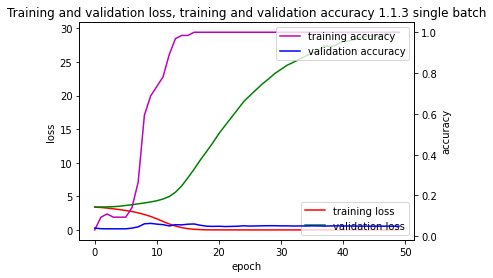

In [13]:
viz_model('results/singlebatch50epochsClass.pt', ' 1.1.3 single batch')



## 1.2 Training on complete dataset [23 marks]

### 1.2.1 Train CNN and show loss graph [6 marks]

Train your model on the complete training dataset, and use the validation set to determine when to stop training.

Display the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.

> As in previous sections, please leave the graph clearly displayed.


In [133]:
def run_model(epoch, resultPath, learningRate, train_loader, model):

  nepochs = epoch
  #results_path = ROOT
  results_path = ROOT+ resultPath
  statsrec = np.zeros((4,nepochs))

  #loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=0.9)

  for epoch in range(nepochs):  # loop over the dataset multiple times
      correct = 0          # number of examples predicted correctly (for accuracy)
      total = 0            # number of examples
      running_loss = 0.0   # accumulated loss (for mean loss)
      n = 0                # number of minibatches
      for data in tqdm(train_loader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward, backward, and update parameters
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
      
          # accumulate loss
          running_loss += loss.item()
          n += 1
          
          # accumulate data for accuracy
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)    # add in the number of labels in this minibatch
          correct += (predicted == labels).sum().item()  # add in the number of correct labels
      
      # collect together statistics for this epoch
      ltrn = running_loss/n
      atrn = correct/total 
      ltst, atst = stats(valid_loader, model)
      statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
      print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validation loss: {ltst.cpu(): .3f} validation accuracy: {atst: .1%}")

      # save network parameters, losses and accuracy
  torch.save({"state_dict": model.state_dict(), "stats": statsrec}, results_path)

In [201]:
loss = loss_fn(outputs, labels)
run_model(50, 'results/completedataset50epochsClass.pt', 0.01, train_loader, model112)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:13<00:00, 12.41it/s]


epoch: 0 training loss:  2.858 training accuracy:  19.0%  validation loss:  2.537 validation accuracy:  28.0%


100%|██████████| 169/169 [00:13<00:00, 12.45it/s]


epoch: 1 training loss:  2.310 training accuracy:  33.2%  validation loss:  2.397 validation accuracy:  32.1%


100%|██████████| 169/169 [00:13<00:00, 12.18it/s]


epoch: 2 training loss:  1.880 training accuracy:  45.3%  validation loss:  2.231 validation accuracy:  38.3%


100%|██████████| 169/169 [00:13<00:00, 12.39it/s]


epoch: 3 training loss:  1.394 training accuracy:  58.9%  validation loss:  2.315 validation accuracy:  38.5%


100%|██████████| 169/169 [00:13<00:00, 12.47it/s]


epoch: 4 training loss:  0.762 training accuracy:  77.2%  validation loss:  2.625 validation accuracy:  36.4%


100%|██████████| 169/169 [00:13<00:00, 12.57it/s]


epoch: 5 training loss:  0.324 training accuracy:  90.5%  validation loss:  3.235 validation accuracy:  39.7%


100%|██████████| 169/169 [00:13<00:00, 12.67it/s]


epoch: 6 training loss:  0.109 training accuracy:  97.1%  validation loss:  3.728 validation accuracy:  38.0%


100%|██████████| 169/169 [00:13<00:00, 12.47it/s]


epoch: 7 training loss:  0.069 training accuracy:  98.2%  validation loss:  3.846 validation accuracy:  38.7%


100%|██████████| 169/169 [00:13<00:00, 12.48it/s]


epoch: 8 training loss:  0.051 training accuracy:  98.6%  validation loss:  4.091 validation accuracy:  40.2%


100%|██████████| 169/169 [00:13<00:00, 12.24it/s]


epoch: 9 training loss:  0.024 training accuracy:  99.4%  validation loss:  4.161 validation accuracy:  41.3%


100%|██████████| 169/169 [00:13<00:00, 12.44it/s]


epoch: 10 training loss:  0.005 training accuracy:  99.9%  validation loss:  4.446 validation accuracy:  41.3%


100%|██████████| 169/169 [00:13<00:00, 12.38it/s]


epoch: 11 training loss:  0.002 training accuracy:  100.0%  validation loss:  4.475 validation accuracy:  42.1%


100%|██████████| 169/169 [00:13<00:00, 12.62it/s]


epoch: 12 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.596 validation accuracy:  42.3%


100%|██████████| 169/169 [00:13<00:00, 12.52it/s]


epoch: 13 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.690 validation accuracy:  42.4%


100%|██████████| 169/169 [00:13<00:00, 12.60it/s]


epoch: 14 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.858 validation accuracy:  42.3%


100%|██████████| 169/169 [00:13<00:00, 12.34it/s]


epoch: 15 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.874 validation accuracy:  42.1%


100%|██████████| 169/169 [00:13<00:00, 12.53it/s]


epoch: 16 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.858 validation accuracy:  42.1%


100%|██████████| 169/169 [00:13<00:00, 12.39it/s]


epoch: 17 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.959 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.32it/s]


epoch: 18 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.011 validation accuracy:  42.1%


100%|██████████| 169/169 [00:13<00:00, 12.43it/s]


epoch: 19 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.049 validation accuracy:  42.1%


100%|██████████| 169/169 [00:13<00:00, 12.44it/s]


epoch: 20 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.031 validation accuracy:  42.1%


100%|██████████| 169/169 [00:13<00:00, 12.54it/s]


epoch: 21 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.084 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.34it/s]


epoch: 22 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.133 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.58it/s]


epoch: 23 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.193 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.49it/s]


epoch: 24 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.140 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.30it/s]


epoch: 25 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.194 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.45it/s]


epoch: 26 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.253 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.52it/s]


epoch: 27 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.261 validation accuracy:  42.1%


100%|██████████| 169/169 [00:13<00:00, 12.26it/s]


epoch: 28 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.289 validation accuracy:  42.1%


100%|██████████| 169/169 [00:13<00:00, 12.50it/s]


epoch: 29 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.305 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.48it/s]


epoch: 30 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.331 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.45it/s]


epoch: 31 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.372 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.43it/s]


epoch: 32 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.394 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.48it/s]


epoch: 33 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.452 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.45it/s]


epoch: 34 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.381 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.44it/s]


epoch: 35 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.486 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.62it/s]


epoch: 36 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.395 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.49it/s]


epoch: 37 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.448 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.58it/s]


epoch: 38 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.483 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.25it/s]


epoch: 39 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.490 validation accuracy:  42.0%


100%|██████████| 169/169 [00:14<00:00, 11.94it/s]


epoch: 40 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.584 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.32it/s]


epoch: 41 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.528 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.45it/s]


epoch: 42 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.499 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.43it/s]


epoch: 43 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.542 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.39it/s]


epoch: 44 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.579 validation accuracy:  42.0%


100%|██████████| 169/169 [00:13<00:00, 12.42it/s]


epoch: 45 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.558 validation accuracy:  42.1%


100%|██████████| 169/169 [00:13<00:00, 12.13it/s]


epoch: 46 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.609 validation accuracy:  42.1%


100%|██████████| 169/169 [00:13<00:00, 12.50it/s]


epoch: 47 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.625 validation accuracy:  42.1%


100%|██████████| 169/169 [00:13<00:00, 12.46it/s]


epoch: 48 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.644 validation accuracy:  42.1%


100%|██████████| 169/169 [00:13<00:00, 12.49it/s]


epoch: 49 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.595 validation accuracy:  42.1%


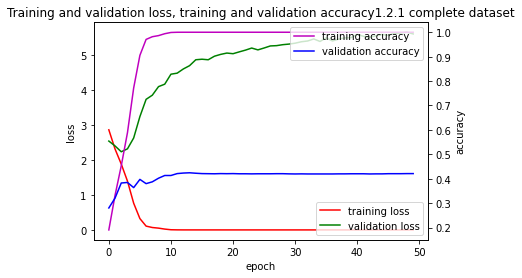

In [14]:
viz_model('results/completedataset50epochsClass.pt', "1.2.1 complete dataset")

It can be clearly seen that the model start overfitting from epoch three onward because the training set at this epoch continue decreasing the loss till it reaches 0 with 100% accuracy. However, the validation set starts increasing the loss until it reaches 5.595, and the accuracy almost remains the same with approximately 42%, which means the model failed to generalize on new data. The optimal number of epochs to stop training and avoid overfitting is three epochs.


### 1.2.2 Finetuning [6 marks]

Now finetune your architecture by implementing at least 2 methods of reducing overfitting and increasing the model's ability to generalise. You are encouraged to further adjust the model after you have done the minimum requirement, to increase your model performance. Please do not use any pre-trained weights from a model trained on ImageNet.


**Method 1:** Data augmentation of your choice

**Method 2:** Adding dropout and/or batch normalisation to the model

If you adjust the Model class, redefine it below and instantiate it as ```model_122a```, ```model_122b```, and so on.



In [175]:
#method 1: Data augmentation of your choice
trnsfrm_augmentation = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean, std)
])

trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [176]:
train_dataset_fine = TinyImageNet30(
    df=data_df[:train_size],
    transform=trnsfrm_augmentation,
)

valid_dataset = TinyImageNet30(
    df=data_df[train_size:].reset_index(drop=True),
    transform=trnsfrm,
)

train_loader = DataLoader(train_dataset_fine, batch_size=64,shuffle=True,num_workers=6)

valid_loader = DataLoader(valid_dataset, batch_size=128,shuffle=True,num_workers=6)


print("len(dataset_train)", len(train_dataset))
print("len(dataset_valid)", len(valid_dataset))

print("len(train_loader)", len(train_loader))
print("len(valid_loader)", len(valid_loader))

len(dataset_train) 10800
len(dataset_valid) 2700
len(train_loader) 169
len(valid_loader) 22


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# 59% validation but overfiting
class model_122c(nn.Module):
  def __init__(self):
    super(model_122c, self).__init__()

    self.conv1 = nn.Conv2d(3, 128, kernel_size= 3, padding= 1)
    self.bn1 = nn.BatchNorm2d(128)
    self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(128, 260, kernel_size= 3, padding= 1)
    self.bn2 = nn.BatchNorm2d(260)
    self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(260, 320, kernel_size= 3, padding= 1)
    self.bn3 = nn.BatchNorm2d(320)
    self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(320, 460, kernel_size= 3, padding= 1)
    self.bn4 = nn.BatchNorm2d(460)
    self.mp4 = nn.MaxPool2d(kernel_size=2, stride=2)

        
    self.fcl1 = nn.Linear(460*4*4, 1500)
    self.dpo1 = nn.Dropout(0.5)

    self.fcl2 = nn.Linear(1500, 700)
    self.dpo2 = nn.Dropout(0.2)

    self.fcl3 = nn.Linear(700, 30)
        
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.bn1(x)
    x = self.mp1(x)

    x = F.relu(self.conv2(x))
    x = self.bn2(x)
    x = self.mp2(x)

    x = F.relu(self.conv3(x))
    x = self.bn3(x)
    x = self.mp3(x)

    x = F.relu(self.conv4(x))
    x = self.bn4(x)
    x = self.mp4(x)

    x = x.reshape(-1, 460*4*4)

    x = self.fcl1(x)
    x = self.dpo1(x)
    x = F.relu(x)

    x = self.fcl2(x)
    x = self.dpo2(x)
    x = F.relu(x)

    x = self.fcl3(x)
    return x
model_122c = model_122c()
model_122c = nn.DataParallel(model_122c)
model_122c = model_122c.to(device) 
summary(model_122c.to(device), input_size=(3, 64, 64))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
         MaxPool2d-3          [-1, 128, 32, 32]               0
            Conv2d-4          [-1, 260, 32, 32]         299,780
       BatchNorm2d-5          [-1, 260, 32, 32]             520
         MaxPool2d-6          [-1, 260, 16, 16]               0
            Conv2d-7          [-1, 320, 16, 16]         749,120
       BatchNorm2d-8          [-1, 320, 16, 16]             640
         MaxPool2d-9            [-1, 320, 8, 8]               0
           Conv2d-10            [-1, 460, 8, 8]       1,325,260
      BatchNorm2d-11            [-1, 460, 8, 8]             920
        MaxPool2d-12            [-1, 460, 4, 4]               0
           Linear-13                 [-1, 1500]      11,041,500
          Dropout-14                 [-

In [ ]:
# 53% with test 50%

model_122d = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 260, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(260),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(260, 320, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(320),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(320*8*8, 1500),
    nn.Dropout(0.5),
    nn.ReLU(),

    nn.Linear(1500, 700),
    nn.Dropout(0.2),
    nn.ReLU(),

    nn.Linear(700, 30)
)

summary(model_122d.to(device), input_size=(3, 64, 64))
model_122d = model_122d.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
          Flatten-13                [-1, 20480]               0
           Linear-14                 [-

In [ ]:
#validation 58% but test 0.56399

model_122e = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 260, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(260),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(260, 320, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(320),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(320, 450, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(450),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(450*4*4, 1500),
    nn.Dropout(0.5),
    nn.ReLU(),

    nn.Linear(1500, 700),
    nn.Dropout(0.2),
    nn.ReLU(),

    nn.Linear(700, 30)
)

summary(model_122e.to(device), input_size=(3, 64, 64))
model_122e = model_122e.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
           Conv2d-13            [-1, 450, 8, 8]       1,296,450
      BatchNorm2d-14            [-1, 45

In [ ]:
# validation 57% test 0.55933

model_122f = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 260, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(260),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(260, 320, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(320),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(320, 450, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(450),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(450*4*4, 1500),
    nn.Dropout(0.5),
    nn.ReLU(),

    nn.Linear(1500, 700),
    nn.Dropout(0.5),
    nn.ReLU(),

    nn.Linear(700, 30)
)

summary(model_122f.to(device), input_size=(3, 64, 64))
model_122f = model_122f.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
           Conv2d-13            [-1, 450, 8, 8]       1,296,450
      BatchNorm2d-14            [-1, 45

In [ ]:
# 

model_122g = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 260, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(260),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(260, 320, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(320),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(320, 450, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(450),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(450*4*4, 1500),
    nn.Dropout(0.2),
    nn.ReLU(),

    nn.Linear(1500, 700),
    nn.Dropout(0.2),
    nn.ReLU(),

    nn.Linear(700, 30)
)

summary(model_122g.to(device), input_size=(3, 64, 64))
model_122g = model_122g.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
           Conv2d-13            [-1, 450, 8, 8]       1,296,450
      BatchNorm2d-14            [-1, 45

In [12]:
#best with 100 epoches
#(the best) validation test 0.6093 with 100 epochs

class model_122h(Module):   
    def __init__(self):
        super(model_122h, self).__init__()

        self.cnn_layers = Sequential(
            Conv2d(3, 128, kernel_size= 3, padding= 1),
            BatchNorm2d(128),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),

            Conv2d(128, 260, kernel_size= 3, padding= 1),
            BatchNorm2d(260),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),

            Conv2d(260, 320, kernel_size= 3, padding= 1),
            BatchNorm2d(320),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),

            Conv2d(320, 450, kernel_size= 3, padding= 1),
            BatchNorm2d(450),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2))

        self.linear_layers = Sequential(
            nn.Linear(450*4*4, 1500),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.Linear(1500, 700),
            nn.Dropout(0.2),
            nn.ReLU(),

            nn.Linear(700, 30)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

model_122h = model_122h()
#model_122c = nn.DataParallel(model_122c)
model_122h = model_122h.to(device) 
summary(model_122h.to(device), input_size=(3, 64, 64))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
           Conv2d-13            [-1, 450, 8, 8]       1,296,450
      BatchNorm2d-14            [-1, 45

In [ ]:
loss_fn = nn.CrossEntropyLoss()
run_model(50,'results/FinecompletedatasetmodelC.pt',0.009, train_loader, model_122c)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 0 training loss:  2.983 training accuracy:  15.3%  validation loss:  2.627 validation accuracy:  24.8%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 1 training loss:  2.608 training accuracy:  24.7%  validation loss:  2.350 validation accuracy:  31.8%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 2 training loss:  2.441 training accuracy:  29.6%  validation loss:  2.246 validation accuracy:  35.6%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 3 training loss:  2.277 training accuracy:  33.9%  validation loss:  2.141 validation accuracy:  36.9%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 4 training loss:  2.113 training accuracy:  38.3%  validation loss:  2.093 validation accuracy:  40.2%


100%|██████████| 169/169 [00:30<00:00,  5.51it/s]


epoch: 5 training loss:  2.030 training accuracy:  40.7%  validation loss:  1.985 validation accuracy:  43.5%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 6 training loss:  1.934 training accuracy:  42.6%  validation loss:  1.852 validation accuracy:  46.3%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 7 training loss:  1.820 training accuracy:  46.2%  validation loss:  1.851 validation accuracy:  47.3%


100%|██████████| 169/169 [00:30<00:00,  5.51it/s]


epoch: 8 training loss:  1.748 training accuracy:  48.6%  validation loss:  1.761 validation accuracy:  48.9%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 9 training loss:  1.660 training accuracy:  50.8%  validation loss:  1.742 validation accuracy:  50.5%


100%|██████████| 169/169 [00:30<00:00,  5.49it/s]


epoch: 10 training loss:  1.580 training accuracy:  53.3%  validation loss:  1.662 validation accuracy:  52.3%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 11 training loss:  1.518 training accuracy:  54.6%  validation loss:  1.720 validation accuracy:  51.3%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 12 training loss:  1.460 training accuracy:  56.3%  validation loss:  1.655 validation accuracy:  53.9%


100%|██████████| 169/169 [00:30<00:00,  5.48it/s]


epoch: 13 training loss:  1.380 training accuracy:  58.7%  validation loss:  1.661 validation accuracy:  52.4%


100%|██████████| 169/169 [00:30<00:00,  5.49it/s]


epoch: 14 training loss:  1.331 training accuracy:  60.2%  validation loss:  1.693 validation accuracy:  54.1%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 15 training loss:  1.303 training accuracy:  61.0%  validation loss:  1.657 validation accuracy:  54.7%


100%|██████████| 169/169 [00:31<00:00,  5.39it/s]


epoch: 16 training loss:  1.224 training accuracy:  63.1%  validation loss:  1.654 validation accuracy:  54.6%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 17 training loss:  1.184 training accuracy:  64.3%  validation loss:  1.692 validation accuracy:  54.9%


100%|██████████| 169/169 [00:30<00:00,  5.54it/s]


epoch: 18 training loss:  1.141 training accuracy:  66.0%  validation loss:  1.684 validation accuracy:  54.0%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 19 training loss:  1.101 training accuracy:  66.9%  validation loss:  1.627 validation accuracy:  56.4%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 20 training loss:  1.041 training accuracy:  68.1%  validation loss:  1.672 validation accuracy:  55.4%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 21 training loss:  1.008 training accuracy:  68.9%  validation loss:  1.625 validation accuracy:  56.7%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 22 training loss:  0.962 training accuracy:  70.7%  validation loss:  1.720 validation accuracy:  55.2%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 23 training loss:  0.913 training accuracy:  72.4%  validation loss:  1.716 validation accuracy:  56.8%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 24 training loss:  0.899 training accuracy:  72.9%  validation loss:  1.726 validation accuracy:  56.4%


100%|██████████| 169/169 [00:30<00:00,  5.57it/s]


epoch: 25 training loss:  0.856 training accuracy:  73.7%  validation loss:  1.705 validation accuracy:  57.3%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 26 training loss:  0.818 training accuracy:  74.9%  validation loss:  1.713 validation accuracy:  57.1%


100%|██████████| 169/169 [00:30<00:00,  5.59it/s]


epoch: 27 training loss:  0.787 training accuracy:  75.6%  validation loss:  1.785 validation accuracy:  57.6%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 28 training loss:  0.776 training accuracy:  76.1%  validation loss:  1.755 validation accuracy:  57.3%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 29 training loss:  0.760 training accuracy:  76.6%  validation loss:  1.662 validation accuracy:  57.6%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 30 training loss:  0.705 training accuracy:  78.2%  validation loss:  1.728 validation accuracy:  57.7%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 31 training loss:  0.666 training accuracy:  79.0%  validation loss:  1.790 validation accuracy:  57.8%


100%|██████████| 169/169 [00:30<00:00,  5.48it/s]


epoch: 32 training loss:  0.657 training accuracy:  80.1%  validation loss:  1.838 validation accuracy:  58.6%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 33 training loss:  0.617 training accuracy:  80.6%  validation loss:  1.950 validation accuracy:  57.7%


100%|██████████| 169/169 [00:30<00:00,  5.45it/s]


epoch: 34 training loss:  0.603 training accuracy:  81.1%  validation loss:  1.877 validation accuracy:  58.3%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 35 training loss:  0.579 training accuracy:  81.6%  validation loss:  1.829 validation accuracy:  58.5%


100%|██████████| 169/169 [00:30<00:00,  5.48it/s]


epoch: 36 training loss:  0.574 training accuracy:  82.2%  validation loss:  1.889 validation accuracy:  57.4%


100%|██████████| 169/169 [00:31<00:00,  5.42it/s]


epoch: 37 training loss:  0.548 training accuracy:  82.8%  validation loss:  1.917 validation accuracy:  56.8%


100%|██████████| 169/169 [00:32<00:00,  5.14it/s]


epoch: 38 training loss:  0.514 training accuracy:  84.1%  validation loss:  1.986 validation accuracy:  57.3%


100%|██████████| 169/169 [00:31<00:00,  5.33it/s]


epoch: 39 training loss:  0.523 training accuracy:  83.7%  validation loss:  1.943 validation accuracy:  58.9%


100%|██████████| 169/169 [00:31<00:00,  5.41it/s]


epoch: 40 training loss:  0.485 training accuracy:  85.0%  validation loss:  1.893 validation accuracy:  57.7%


100%|██████████| 169/169 [00:31<00:00,  5.45it/s]


epoch: 41 training loss:  0.479 training accuracy:  85.0%  validation loss:  1.971 validation accuracy:  57.7%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 42 training loss:  0.487 training accuracy:  84.7%  validation loss:  1.997 validation accuracy:  58.3%


100%|██████████| 169/169 [00:31<00:00,  5.40it/s]


epoch: 43 training loss:  0.451 training accuracy:  86.2%  validation loss:  1.955 validation accuracy:  57.9%


100%|██████████| 169/169 [00:32<00:00,  5.20it/s]


epoch: 44 training loss:  0.426 training accuracy:  86.7%  validation loss:  1.915 validation accuracy:  58.7%


100%|██████████| 169/169 [00:32<00:00,  5.14it/s]


epoch: 45 training loss:  0.427 training accuracy:  86.6%  validation loss:  1.868 validation accuracy:  59.3%


100%|██████████| 169/169 [00:32<00:00,  5.19it/s]


epoch: 46 training loss:  0.415 training accuracy:  87.0%  validation loss:  2.006 validation accuracy:  59.2%


100%|██████████| 169/169 [00:31<00:00,  5.36it/s]


epoch: 47 training loss:  0.418 training accuracy:  87.1%  validation loss:  2.106 validation accuracy:  58.1%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 48 training loss:  0.387 training accuracy:  87.8%  validation loss:  2.025 validation accuracy:  58.6%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 49 training loss:  0.384 training accuracy:  88.1%  validation loss:  2.045 validation accuracy:  58.2%


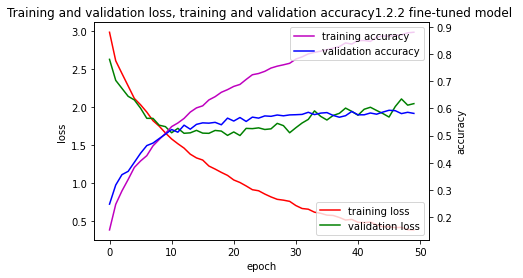

In [22]:
viz_model('results/FinecompletedatasetmodelC.pt', "1.2.2 fine-tuned model ")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
run_model(50,'results/FinecompletedatasetmodelD.pt',0.009, train_loader, model_122d)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [06:12<00:00,  2.20s/it]


epoch: 0 training loss:  3.147 training accuracy:  11.4%  validation loss:  2.840 validation accuracy:  17.1%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 1 training loss:  2.830 training accuracy:  19.0%  validation loss:  2.667 validation accuracy:  22.6%


100%|██████████| 169/169 [00:30<00:00,  5.58it/s]


epoch: 2 training loss:  2.726 training accuracy:  20.6%  validation loss:  2.663 validation accuracy:  24.8%


100%|██████████| 169/169 [00:29<00:00,  5.66it/s]


epoch: 3 training loss:  2.652 training accuracy:  23.5%  validation loss:  2.492 validation accuracy:  26.9%


100%|██████████| 169/169 [00:30<00:00,  5.58it/s]


epoch: 4 training loss:  2.586 training accuracy:  25.1%  validation loss:  2.498 validation accuracy:  26.9%


100%|██████████| 169/169 [00:30<00:00,  5.63it/s]


epoch: 5 training loss:  2.522 training accuracy:  26.7%  validation loss:  2.409 validation accuracy:  30.2%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 6 training loss:  2.487 training accuracy:  28.4%  validation loss:  2.363 validation accuracy:  33.1%


100%|██████████| 169/169 [00:29<00:00,  5.77it/s]


epoch: 7 training loss:  2.426 training accuracy:  29.2%  validation loss:  2.347 validation accuracy:  32.2%


100%|██████████| 169/169 [00:30<00:00,  5.58it/s]


epoch: 8 training loss:  2.381 training accuracy:  31.3%  validation loss:  2.299 validation accuracy:  33.8%


100%|██████████| 169/169 [00:30<00:00,  5.54it/s]


epoch: 9 training loss:  2.352 training accuracy:  31.4%  validation loss:  2.245 validation accuracy:  35.3%


100%|██████████| 169/169 [00:30<00:00,  5.49it/s]


epoch: 10 training loss:  2.291 training accuracy:  33.5%  validation loss:  2.242 validation accuracy:  35.8%


100%|██████████| 169/169 [00:31<00:00,  5.30it/s]


epoch: 11 training loss:  2.270 training accuracy:  34.1%  validation loss:  2.252 validation accuracy:  36.3%


100%|██████████| 169/169 [00:31<00:00,  5.34it/s]


epoch: 12 training loss:  2.221 training accuracy:  35.1%  validation loss:  2.154 validation accuracy:  38.8%


100%|██████████| 169/169 [00:29<00:00,  5.81it/s]


epoch: 13 training loss:  2.173 training accuracy:  36.2%  validation loss:  2.130 validation accuracy:  38.6%


100%|██████████| 169/169 [00:30<00:00,  5.57it/s]


epoch: 14 training loss:  2.156 training accuracy:  37.3%  validation loss:  2.162 validation accuracy:  39.7%


100%|██████████| 169/169 [00:29<00:00,  5.66it/s]


epoch: 15 training loss:  2.104 training accuracy:  38.8%  validation loss:  2.074 validation accuracy:  39.8%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 16 training loss:  2.097 training accuracy:  38.7%  validation loss:  2.088 validation accuracy:  40.3%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 17 training loss:  2.039 training accuracy:  40.6%  validation loss:  2.029 validation accuracy:  43.2%


100%|██████████| 169/169 [00:29<00:00,  5.74it/s]


epoch: 18 training loss:  2.032 training accuracy:  40.5%  validation loss:  1.980 validation accuracy:  42.0%


100%|██████████| 169/169 [00:30<00:00,  5.57it/s]


epoch: 19 training loss:  1.988 training accuracy:  41.6%  validation loss:  1.996 validation accuracy:  43.3%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 20 training loss:  1.960 training accuracy:  42.8%  validation loss:  1.964 validation accuracy:  43.7%


100%|██████████| 169/169 [00:29<00:00,  5.67it/s]


epoch: 21 training loss:  1.943 training accuracy:  42.4%  validation loss:  2.008 validation accuracy:  44.0%


100%|██████████| 169/169 [00:29<00:00,  5.70it/s]


epoch: 22 training loss:  1.919 training accuracy:  43.4%  validation loss:  1.985 validation accuracy:  43.4%


100%|██████████| 169/169 [00:29<00:00,  5.65it/s]


epoch: 23 training loss:  1.891 training accuracy:  43.7%  validation loss:  1.985 validation accuracy:  45.0%


100%|██████████| 169/169 [00:30<00:00,  5.59it/s]


epoch: 24 training loss:  1.866 training accuracy:  45.0%  validation loss:  1.949 validation accuracy:  45.3%


100%|██████████| 169/169 [00:29<00:00,  5.70it/s]


epoch: 25 training loss:  1.815 training accuracy:  46.4%  validation loss:  1.905 validation accuracy:  46.6%


100%|██████████| 169/169 [00:29<00:00,  5.70it/s]


epoch: 26 training loss:  1.819 training accuracy:  46.2%  validation loss:  1.993 validation accuracy:  44.2%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 27 training loss:  1.795 training accuracy:  46.5%  validation loss:  1.871 validation accuracy:  45.7%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 28 training loss:  1.763 training accuracy:  47.5%  validation loss:  1.870 validation accuracy:  45.9%


100%|██████████| 169/169 [00:29<00:00,  5.63it/s]


epoch: 29 training loss:  1.755 training accuracy:  48.0%  validation loss:  1.889 validation accuracy:  47.0%


100%|██████████| 169/169 [00:29<00:00,  5.66it/s]


epoch: 30 training loss:  1.711 training accuracy:  49.1%  validation loss:  1.859 validation accuracy:  46.6%


100%|██████████| 169/169 [00:30<00:00,  5.62it/s]


epoch: 31 training loss:  1.711 training accuracy:  49.6%  validation loss:  1.835 validation accuracy:  48.4%


100%|██████████| 169/169 [00:29<00:00,  5.69it/s]


epoch: 32 training loss:  1.676 training accuracy:  50.0%  validation loss:  1.799 validation accuracy:  48.6%


100%|██████████| 169/169 [00:29<00:00,  5.67it/s]


epoch: 33 training loss:  1.655 training accuracy:  50.3%  validation loss:  1.868 validation accuracy:  47.0%


100%|██████████| 169/169 [00:29<00:00,  5.72it/s]


epoch: 34 training loss:  1.652 training accuracy:  50.7%  validation loss:  1.832 validation accuracy:  49.2%


100%|██████████| 169/169 [00:30<00:00,  5.61it/s]


epoch: 35 training loss:  1.609 training accuracy:  52.0%  validation loss:  1.802 validation accuracy:  48.2%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 36 training loss:  1.580 training accuracy:  52.3%  validation loss:  1.794 validation accuracy:  49.2%


100%|██████████| 169/169 [00:31<00:00,  5.39it/s]


epoch: 37 training loss:  1.546 training accuracy:  53.1%  validation loss:  1.821 validation accuracy:  49.0%


100%|██████████| 169/169 [00:30<00:00,  5.46it/s]


epoch: 38 training loss:  1.559 training accuracy:  52.5%  validation loss:  1.785 validation accuracy:  48.7%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 39 training loss:  1.541 training accuracy:  53.1%  validation loss:  1.743 validation accuracy:  49.8%


100%|██████████| 169/169 [00:29<00:00,  5.67it/s]


epoch: 40 training loss:  1.501 training accuracy:  54.3%  validation loss:  1.808 validation accuracy:  50.7%


100%|██████████| 169/169 [00:29<00:00,  5.69it/s]


epoch: 41 training loss:  1.497 training accuracy:  54.5%  validation loss:  1.786 validation accuracy:  50.4%


100%|██████████| 169/169 [00:30<00:00,  5.59it/s]


epoch: 42 training loss:  1.445 training accuracy:  56.2%  validation loss:  1.766 validation accuracy:  50.6%


100%|██████████| 169/169 [00:29<00:00,  5.73it/s]


epoch: 43 training loss:  1.434 training accuracy:  56.6%  validation loss:  1.687 validation accuracy:  51.9%


100%|██████████| 169/169 [00:29<00:00,  5.66it/s]


epoch: 44 training loss:  1.426 training accuracy:  57.3%  validation loss:  1.727 validation accuracy:  51.4%


100%|██████████| 169/169 [00:29<00:00,  5.66it/s]


epoch: 45 training loss:  1.399 training accuracy:  57.2%  validation loss:  1.705 validation accuracy:  52.3%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 46 training loss:  1.374 training accuracy:  58.2%  validation loss:  1.821 validation accuracy:  49.1%


100%|██████████| 169/169 [00:29<00:00,  5.76it/s]


epoch: 47 training loss:  1.376 training accuracy:  58.1%  validation loss:  1.719 validation accuracy:  52.7%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 48 training loss:  1.351 training accuracy:  58.7%  validation loss:  1.749 validation accuracy:  51.9%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 49 training loss:  1.332 training accuracy:  59.2%  validation loss:  1.694 validation accuracy:  53.1%


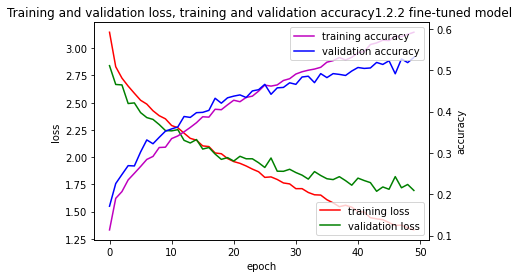

In [21]:
viz_model('results/FinecompletedatasetmodelD.pt', "1.2.2 fine-tuned model ")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
run_model(50,'results/FinecompletedatasetmodelE.pt',0.009, train_loader, model_122e)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:32<00:00,  5.21it/s]


epoch: 0 training loss:  3.092 training accuracy:  12.5%  validation loss:  2.735 validation accuracy:  20.6%


100%|██████████| 169/169 [00:32<00:00,  5.19it/s]


epoch: 1 training loss:  2.722 training accuracy:  21.0%  validation loss:  2.599 validation accuracy:  24.9%


100%|██████████| 169/169 [00:32<00:00,  5.17it/s]


epoch: 2 training loss:  2.599 training accuracy:  24.7%  validation loss:  2.483 validation accuracy:  27.4%


100%|██████████| 169/169 [00:32<00:00,  5.18it/s]


epoch: 3 training loss:  2.489 training accuracy:  26.9%  validation loss:  2.309 validation accuracy:  32.4%


100%|██████████| 169/169 [00:32<00:00,  5.15it/s]


epoch: 4 training loss:  2.402 training accuracy:  29.6%  validation loss:  2.297 validation accuracy:  33.7%


100%|██████████| 169/169 [00:33<00:00,  5.11it/s]


epoch: 5 training loss:  2.303 training accuracy:  33.0%  validation loss:  2.241 validation accuracy:  34.9%


100%|██████████| 169/169 [00:32<00:00,  5.21it/s]


epoch: 6 training loss:  2.257 training accuracy:  34.3%  validation loss:  2.119 validation accuracy:  38.7%


100%|██████████| 169/169 [00:32<00:00,  5.25it/s]


epoch: 7 training loss:  2.178 training accuracy:  36.8%  validation loss:  2.045 validation accuracy:  39.4%


100%|██████████| 169/169 [00:32<00:00,  5.28it/s]


epoch: 8 training loss:  2.098 training accuracy:  38.5%  validation loss:  2.043 validation accuracy:  40.3%


100%|██████████| 169/169 [00:32<00:00,  5.25it/s]


epoch: 9 training loss:  2.029 training accuracy:  39.7%  validation loss:  2.043 validation accuracy:  40.7%


100%|██████████| 169/169 [00:31<00:00,  5.28it/s]


epoch: 10 training loss:  1.988 training accuracy:  41.4%  validation loss:  1.963 validation accuracy:  42.2%


100%|██████████| 169/169 [00:32<00:00,  5.27it/s]


epoch: 11 training loss:  1.926 training accuracy:  42.9%  validation loss:  1.888 validation accuracy:  43.7%


100%|██████████| 169/169 [00:31<00:00,  5.37it/s]


epoch: 12 training loss:  1.871 training accuracy:  44.7%  validation loss:  1.855 validation accuracy:  45.6%


100%|██████████| 169/169 [00:31<00:00,  5.36it/s]


epoch: 13 training loss:  1.854 training accuracy:  45.0%  validation loss:  1.836 validation accuracy:  46.8%


100%|██████████| 169/169 [00:31<00:00,  5.31it/s]


epoch: 14 training loss:  1.802 training accuracy:  46.5%  validation loss:  1.876 validation accuracy:  46.3%


100%|██████████| 169/169 [00:31<00:00,  5.34it/s]


epoch: 15 training loss:  1.762 training accuracy:  47.5%  validation loss:  1.813 validation accuracy:  48.9%


100%|██████████| 169/169 [00:31<00:00,  5.34it/s]


epoch: 16 training loss:  1.718 training accuracy:  48.9%  validation loss:  1.801 validation accuracy:  46.9%


100%|██████████| 169/169 [00:31<00:00,  5.31it/s]


epoch: 17 training loss:  1.693 training accuracy:  49.8%  validation loss:  1.725 validation accuracy:  50.2%


100%|██████████| 169/169 [00:31<00:00,  5.34it/s]


epoch: 18 training loss:  1.653 training accuracy:  50.7%  validation loss:  1.759 validation accuracy:  49.4%


100%|██████████| 169/169 [00:31<00:00,  5.42it/s]


epoch: 19 training loss:  1.631 training accuracy:  50.7%  validation loss:  1.770 validation accuracy:  48.4%


100%|██████████| 169/169 [00:30<00:00,  5.46it/s]


epoch: 20 training loss:  1.592 training accuracy:  52.4%  validation loss:  1.706 validation accuracy:  49.5%


100%|██████████| 169/169 [00:31<00:00,  5.41it/s]


epoch: 21 training loss:  1.569 training accuracy:  52.7%  validation loss:  1.762 validation accuracy:  50.9%


100%|██████████| 169/169 [00:31<00:00,  5.41it/s]


epoch: 22 training loss:  1.552 training accuracy:  53.7%  validation loss:  1.630 validation accuracy:  52.2%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 23 training loss:  1.508 training accuracy:  54.5%  validation loss:  1.737 validation accuracy:  50.4%


100%|██████████| 169/169 [00:31<00:00,  5.42it/s]


epoch: 24 training loss:  1.487 training accuracy:  55.6%  validation loss:  1.666 validation accuracy:  53.0%


100%|██████████| 169/169 [00:31<00:00,  5.42it/s]


epoch: 25 training loss:  1.452 training accuracy:  55.8%  validation loss:  1.666 validation accuracy:  52.9%


100%|██████████| 169/169 [00:31<00:00,  5.39it/s]


epoch: 26 training loss:  1.428 training accuracy:  56.9%  validation loss:  1.718 validation accuracy:  52.4%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 27 training loss:  1.433 training accuracy:  57.0%  validation loss:  1.690 validation accuracy:  52.9%


100%|██████████| 169/169 [00:30<00:00,  5.45it/s]


epoch: 28 training loss:  1.389 training accuracy:  57.6%  validation loss:  1.696 validation accuracy:  53.5%


100%|██████████| 169/169 [00:31<00:00,  5.45it/s]


epoch: 29 training loss:  1.358 training accuracy:  58.7%  validation loss:  1.652 validation accuracy:  54.4%


100%|██████████| 169/169 [00:32<00:00,  5.25it/s]


epoch: 30 training loss:  1.348 training accuracy:  58.6%  validation loss:  1.594 validation accuracy:  53.6%


100%|██████████| 169/169 [00:35<00:00,  4.79it/s]


epoch: 31 training loss:  1.323 training accuracy:  59.5%  validation loss:  1.622 validation accuracy:  53.9%


100%|██████████| 169/169 [00:32<00:00,  5.15it/s]


epoch: 32 training loss:  1.304 training accuracy:  60.1%  validation loss:  1.649 validation accuracy:  54.8%


100%|██████████| 169/169 [00:34<00:00,  4.93it/s]


epoch: 33 training loss:  1.267 training accuracy:  61.1%  validation loss:  1.596 validation accuracy:  54.8%


100%|██████████| 169/169 [00:32<00:00,  5.26it/s]


epoch: 34 training loss:  1.261 training accuracy:  60.9%  validation loss:  1.588 validation accuracy:  55.2%


100%|██████████| 169/169 [00:32<00:00,  5.22it/s]


epoch: 35 training loss:  1.224 training accuracy:  61.9%  validation loss:  1.585 validation accuracy:  56.4%


100%|██████████| 169/169 [00:31<00:00,  5.31it/s]


epoch: 36 training loss:  1.210 training accuracy:  62.8%  validation loss:  1.656 validation accuracy:  55.1%


100%|██████████| 169/169 [00:32<00:00,  5.26it/s]


epoch: 37 training loss:  1.183 training accuracy:  63.5%  validation loss:  1.679 validation accuracy:  55.1%


100%|██████████| 169/169 [00:32<00:00,  5.25it/s]


epoch: 38 training loss:  1.159 training accuracy:  64.2%  validation loss:  1.589 validation accuracy:  56.1%


100%|██████████| 169/169 [00:37<00:00,  4.48it/s]


epoch: 39 training loss:  1.137 training accuracy:  64.7%  validation loss:  1.617 validation accuracy:  56.1%


100%|██████████| 169/169 [00:40<00:00,  4.20it/s]


epoch: 40 training loss:  1.121 training accuracy:  64.9%  validation loss:  1.597 validation accuracy:  56.8%


100%|██████████| 169/169 [00:40<00:00,  4.21it/s]


epoch: 41 training loss:  1.112 training accuracy:  65.9%  validation loss:  1.677 validation accuracy:  56.3%


100%|██████████| 169/169 [00:40<00:00,  4.19it/s]


epoch: 42 training loss:  1.074 training accuracy:  66.5%  validation loss:  1.613 validation accuracy:  55.7%


100%|██████████| 169/169 [00:39<00:00,  4.23it/s]


epoch: 43 training loss:  1.072 training accuracy:  67.1%  validation loss:  1.621 validation accuracy:  57.0%


100%|██████████| 169/169 [00:40<00:00,  4.21it/s]


epoch: 44 training loss:  1.062 training accuracy:  66.9%  validation loss:  1.616 validation accuracy:  57.0%


100%|██████████| 169/169 [00:39<00:00,  4.25it/s]


epoch: 45 training loss:  1.035 training accuracy:  67.9%  validation loss:  1.645 validation accuracy:  57.5%


100%|██████████| 169/169 [00:40<00:00,  4.22it/s]


epoch: 46 training loss:  0.999 training accuracy:  69.1%  validation loss:  1.637 validation accuracy:  57.4%


100%|██████████| 169/169 [00:39<00:00,  4.23it/s]


epoch: 47 training loss:  0.984 training accuracy:  69.4%  validation loss:  1.585 validation accuracy:  56.7%


100%|██████████| 169/169 [00:39<00:00,  4.24it/s]


epoch: 48 training loss:  0.974 training accuracy:  69.7%  validation loss:  1.620 validation accuracy:  57.9%


100%|██████████| 169/169 [00:39<00:00,  4.24it/s]


epoch: 49 training loss:  0.953 training accuracy:  69.8%  validation loss:  1.576 validation accuracy:  58.1%


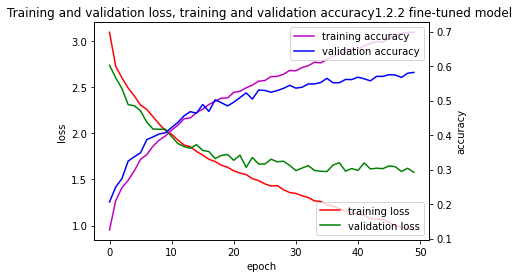

In [20]:
viz_model('results/FinecompletedatasetmodelE.pt', "1.2.2 fine-tuned model ")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
run_model(50,'results/FinecompletedatasetmodelF.pt',0.009, train_loader, model_122f)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:32<00:00,  5.14it/s]


epoch: 0 training loss:  3.196 training accuracy:  10.3%  validation loss:  2.882 validation accuracy:  16.7%


100%|██████████| 169/169 [00:31<00:00,  5.31it/s]


epoch: 1 training loss:  2.835 training accuracy:  18.1%  validation loss:  2.672 validation accuracy:  22.1%


100%|██████████| 169/169 [00:32<00:00,  5.19it/s]


epoch: 2 training loss:  2.715 training accuracy:  21.5%  validation loss:  2.576 validation accuracy:  26.7%


100%|██████████| 169/169 [00:32<00:00,  5.22it/s]


epoch: 3 training loss:  2.613 training accuracy:  24.7%  validation loss:  2.448 validation accuracy:  28.7%


100%|██████████| 169/169 [00:31<00:00,  5.33it/s]


epoch: 4 training loss:  2.554 training accuracy:  25.6%  validation loss:  2.468 validation accuracy:  29.0%


100%|██████████| 169/169 [00:31<00:00,  5.33it/s]


epoch: 5 training loss:  2.483 training accuracy:  28.2%  validation loss:  2.357 validation accuracy:  31.7%


100%|██████████| 169/169 [00:32<00:00,  5.18it/s]


epoch: 6 training loss:  2.420 training accuracy:  29.9%  validation loss:  2.301 validation accuracy:  33.3%


100%|██████████| 169/169 [00:31<00:00,  5.39it/s]


epoch: 7 training loss:  2.363 training accuracy:  31.4%  validation loss:  2.215 validation accuracy:  34.0%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 8 training loss:  2.303 training accuracy:  34.0%  validation loss:  2.256 validation accuracy:  34.3%


100%|██████████| 169/169 [00:28<00:00,  5.90it/s]


epoch: 9 training loss:  2.258 training accuracy:  35.0%  validation loss:  2.152 validation accuracy:  36.9%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 10 training loss:  2.205 training accuracy:  36.3%  validation loss:  2.200 validation accuracy:  35.9%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 11 training loss:  2.144 training accuracy:  37.9%  validation loss:  2.052 validation accuracy:  42.2%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 12 training loss:  2.113 training accuracy:  38.5%  validation loss:  2.056 validation accuracy:  41.7%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 13 training loss:  2.061 training accuracy:  40.2%  validation loss:  2.070 validation accuracy:  40.7%


100%|██████████| 169/169 [00:28<00:00,  5.91it/s]


epoch: 14 training loss:  2.025 training accuracy:  41.0%  validation loss:  2.034 validation accuracy:  42.2%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 15 training loss:  1.960 training accuracy:  42.3%  validation loss:  2.027 validation accuracy:  42.4%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 16 training loss:  1.957 training accuracy:  42.4%  validation loss:  1.980 validation accuracy:  44.1%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 17 training loss:  1.927 training accuracy:  44.4%  validation loss:  1.936 validation accuracy:  43.9%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 18 training loss:  1.883 training accuracy:  45.3%  validation loss:  1.925 validation accuracy:  45.6%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 19 training loss:  1.842 training accuracy:  46.6%  validation loss:  1.856 validation accuracy:  45.9%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 20 training loss:  1.830 training accuracy:  46.2%  validation loss:  1.955 validation accuracy:  45.4%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 21 training loss:  1.809 training accuracy:  47.4%  validation loss:  1.864 validation accuracy:  47.7%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 22 training loss:  1.766 training accuracy:  48.4%  validation loss:  1.864 validation accuracy:  46.9%


100%|██████████| 169/169 [00:28<00:00,  5.92it/s]


epoch: 23 training loss:  1.741 training accuracy:  48.7%  validation loss:  1.861 validation accuracy:  47.9%


100%|██████████| 169/169 [00:28<00:00,  5.95it/s]


epoch: 24 training loss:  1.686 training accuracy:  50.2%  validation loss:  1.802 validation accuracy:  48.3%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 25 training loss:  1.685 training accuracy:  50.9%  validation loss:  1.802 validation accuracy:  48.3%


100%|██████████| 169/169 [00:27<00:00,  6.05it/s]


epoch: 26 training loss:  1.659 training accuracy:  51.3%  validation loss:  1.742 validation accuracy:  50.3%


100%|██████████| 169/169 [00:27<00:00,  6.08it/s]


epoch: 27 training loss:  1.638 training accuracy:  52.1%  validation loss:  1.845 validation accuracy:  48.8%


100%|██████████| 169/169 [00:28<00:00,  5.92it/s]


epoch: 28 training loss:  1.623 training accuracy:  52.3%  validation loss:  1.715 validation accuracy:  51.6%


100%|██████████| 169/169 [00:28<00:00,  5.91it/s]


epoch: 29 training loss:  1.597 training accuracy:  53.1%  validation loss:  1.748 validation accuracy:  51.8%


100%|██████████| 169/169 [00:27<00:00,  6.06it/s]


epoch: 30 training loss:  1.571 training accuracy:  53.6%  validation loss:  1.727 validation accuracy:  51.5%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 31 training loss:  1.550 training accuracy:  53.9%  validation loss:  1.702 validation accuracy:  52.2%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 32 training loss:  1.534 training accuracy:  54.5%  validation loss:  1.703 validation accuracy:  52.5%


100%|██████████| 169/169 [00:28<00:00,  5.94it/s]


epoch: 33 training loss:  1.506 training accuracy:  55.6%  validation loss:  1.687 validation accuracy:  53.6%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 34 training loss:  1.476 training accuracy:  56.5%  validation loss:  1.685 validation accuracy:  52.9%


100%|██████████| 169/169 [00:27<00:00,  6.07it/s]


epoch: 35 training loss:  1.465 training accuracy:  56.7%  validation loss:  1.686 validation accuracy:  52.6%


100%|██████████| 169/169 [00:27<00:00,  6.09it/s]


epoch: 36 training loss:  1.447 training accuracy:  57.0%  validation loss:  1.673 validation accuracy:  53.1%


100%|██████████| 169/169 [00:27<00:00,  6.05it/s]


epoch: 37 training loss:  1.426 training accuracy:  57.7%  validation loss:  1.658 validation accuracy:  55.0%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 38 training loss:  1.411 training accuracy:  57.8%  validation loss:  1.672 validation accuracy:  54.2%


100%|██████████| 169/169 [00:27<00:00,  6.06it/s]


epoch: 39 training loss:  1.377 training accuracy:  59.1%  validation loss:  1.626 validation accuracy:  54.1%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 40 training loss:  1.363 training accuracy:  59.5%  validation loss:  1.640 validation accuracy:  52.9%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 41 training loss:  1.347 training accuracy:  59.9%  validation loss:  1.657 validation accuracy:  54.6%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 42 training loss:  1.308 training accuracy:  60.4%  validation loss:  1.601 validation accuracy:  54.8%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 43 training loss:  1.272 training accuracy:  61.9%  validation loss:  1.639 validation accuracy:  55.3%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 44 training loss:  1.277 training accuracy:  61.6%  validation loss:  1.652 validation accuracy:  55.5%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 45 training loss:  1.262 training accuracy:  62.0%  validation loss:  1.691 validation accuracy:  53.9%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 46 training loss:  1.257 training accuracy:  62.5%  validation loss:  1.638 validation accuracy:  55.6%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 47 training loss:  1.210 training accuracy:  63.5%  validation loss:  1.653 validation accuracy:  56.2%


100%|██████████| 169/169 [00:27<00:00,  6.06it/s]


epoch: 48 training loss:  1.215 training accuracy:  63.7%  validation loss:  1.670 validation accuracy:  57.1%


100%|██████████| 169/169 [00:27<00:00,  6.08it/s]


epoch: 49 training loss:  1.193 training accuracy:  64.2%  validation loss:  1.576 validation accuracy:  57.0%


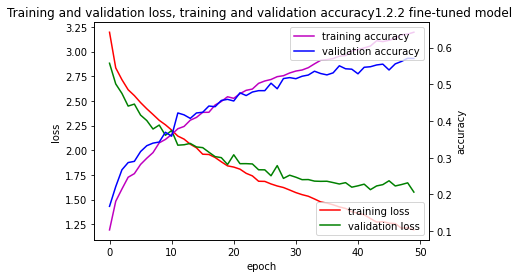

In [19]:
viz_model('results/FinecompletedatasetmodelF.pt', "1.2.2 fine-tuned model ")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
run_model(100,'results/FinecompletedatasetmodelH.pt',0.009, train_loader, model_122h)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 0 training loss:  3.107 training accuracy:  11.3%  validation loss:  2.835 validation accuracy:  17.4%


100%|██████████| 169/169 [00:29<00:00,  5.73it/s]


epoch: 1 training loss:  2.736 training accuracy:  20.8%  validation loss:  2.556 validation accuracy:  25.6%


100%|██████████| 169/169 [00:28<00:00,  5.87it/s]


epoch: 2 training loss:  2.585 training accuracy:  24.8%  validation loss:  2.416 validation accuracy:  29.6%


100%|██████████| 169/169 [00:30<00:00,  5.61it/s]


epoch: 3 training loss:  2.481 training accuracy:  27.9%  validation loss:  2.325 validation accuracy:  33.0%


100%|██████████| 169/169 [00:29<00:00,  5.63it/s]


epoch: 4 training loss:  2.393 training accuracy:  30.4%  validation loss:  2.276 validation accuracy:  34.8%


100%|██████████| 169/169 [00:29<00:00,  5.64it/s]


epoch: 5 training loss:  2.329 training accuracy:  32.3%  validation loss:  2.264 validation accuracy:  34.4%


100%|██████████| 169/169 [00:29<00:00,  5.69it/s]


epoch: 6 training loss:  2.256 training accuracy:  33.9%  validation loss:  2.100 validation accuracy:  37.0%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 7 training loss:  2.161 training accuracy:  36.8%  validation loss:  2.154 validation accuracy:  38.4%


100%|██████████| 169/169 [00:30<00:00,  5.58it/s]


epoch: 8 training loss:  2.090 training accuracy:  38.2%  validation loss:  2.091 validation accuracy:  39.1%


100%|██████████| 169/169 [00:30<00:00,  5.61it/s]


epoch: 9 training loss:  2.049 training accuracy:  40.1%  validation loss:  2.018 validation accuracy:  41.8%


100%|██████████| 169/169 [00:30<00:00,  5.60it/s]


epoch: 10 training loss:  1.997 training accuracy:  41.4%  validation loss:  2.013 validation accuracy:  42.5%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 11 training loss:  1.944 training accuracy:  42.7%  validation loss:  1.933 validation accuracy:  42.3%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 12 training loss:  1.910 training accuracy:  44.5%  validation loss:  1.936 validation accuracy:  44.6%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 13 training loss:  1.844 training accuracy:  45.2%  validation loss:  1.846 validation accuracy:  45.9%


100%|██████████| 169/169 [00:30<00:00,  5.57it/s]


epoch: 14 training loss:  1.804 training accuracy:  46.5%  validation loss:  1.797 validation accuracy:  46.9%


100%|██████████| 169/169 [00:30<00:00,  5.60it/s]


epoch: 15 training loss:  1.771 training accuracy:  47.3%  validation loss:  1.891 validation accuracy:  46.4%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 16 training loss:  1.740 training accuracy:  48.3%  validation loss:  1.779 validation accuracy:  48.0%


100%|██████████| 169/169 [00:30<00:00,  5.61it/s]


epoch: 17 training loss:  1.693 training accuracy:  49.4%  validation loss:  1.812 validation accuracy:  48.2%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 18 training loss:  1.675 training accuracy:  50.4%  validation loss:  1.823 validation accuracy:  46.6%


100%|██████████| 169/169 [00:30<00:00,  5.57it/s]


epoch: 19 training loss:  1.636 training accuracy:  51.5%  validation loss:  1.907 validation accuracy:  48.5%


100%|██████████| 169/169 [00:30<00:00,  5.46it/s]


epoch: 20 training loss:  1.616 training accuracy:  51.8%  validation loss:  1.796 validation accuracy:  48.5%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 21 training loss:  1.568 training accuracy:  52.7%  validation loss:  1.742 validation accuracy:  50.2%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 22 training loss:  1.563 training accuracy:  53.2%  validation loss:  1.839 validation accuracy:  49.1%


100%|██████████| 169/169 [00:30<00:00,  5.46it/s]


epoch: 23 training loss:  1.521 training accuracy:  54.6%  validation loss:  1.762 validation accuracy:  49.7%


100%|██████████| 169/169 [00:30<00:00,  5.62it/s]


epoch: 24 training loss:  1.512 training accuracy:  54.4%  validation loss:  1.674 validation accuracy:  51.3%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 25 training loss:  1.450 training accuracy:  56.2%  validation loss:  1.792 validation accuracy:  50.4%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 26 training loss:  1.446 training accuracy:  56.3%  validation loss:  1.705 validation accuracy:  51.8%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 27 training loss:  1.410 training accuracy:  57.8%  validation loss:  1.771 validation accuracy:  51.0%


100%|██████████| 169/169 [00:31<00:00,  5.37it/s]


epoch: 28 training loss:  1.391 training accuracy:  57.5%  validation loss:  1.675 validation accuracy:  52.3%


100%|██████████| 169/169 [00:31<00:00,  5.39it/s]


epoch: 29 training loss:  1.389 training accuracy:  58.0%  validation loss:  1.683 validation accuracy:  53.4%


100%|██████████| 169/169 [00:31<00:00,  5.39it/s]


epoch: 30 training loss:  1.372 training accuracy:  58.8%  validation loss:  1.690 validation accuracy:  52.5%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 31 training loss:  1.322 training accuracy:  59.8%  validation loss:  1.713 validation accuracy:  53.1%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 32 training loss:  1.311 training accuracy:  60.7%  validation loss:  1.631 validation accuracy:  55.2%


100%|██████████| 169/169 [00:30<00:00,  5.58it/s]


epoch: 33 training loss:  1.264 training accuracy:  61.1%  validation loss:  1.624 validation accuracy:  54.6%


100%|██████████| 169/169 [00:30<00:00,  5.48it/s]


epoch: 34 training loss:  1.261 training accuracy:  61.6%  validation loss:  1.670 validation accuracy:  53.4%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 35 training loss:  1.247 training accuracy:  62.0%  validation loss:  1.587 validation accuracy:  54.7%


100%|██████████| 169/169 [00:30<00:00,  5.58it/s]


epoch: 36 training loss:  1.206 training accuracy:  62.5%  validation loss:  1.668 validation accuracy:  54.1%


100%|██████████| 169/169 [00:31<00:00,  5.45it/s]


epoch: 37 training loss:  1.197 training accuracy:  63.6%  validation loss:  1.606 validation accuracy:  55.5%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 38 training loss:  1.166 training accuracy:  64.0%  validation loss:  1.640 validation accuracy:  54.4%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 39 training loss:  1.165 training accuracy:  64.2%  validation loss:  1.627 validation accuracy:  55.8%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 40 training loss:  1.137 training accuracy:  65.0%  validation loss:  1.584 validation accuracy:  56.3%


100%|██████████| 169/169 [00:30<00:00,  5.60it/s]


epoch: 41 training loss:  1.119 training accuracy:  65.3%  validation loss:  1.632 validation accuracy:  55.9%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 42 training loss:  1.098 training accuracy:  65.5%  validation loss:  1.614 validation accuracy:  55.7%


100%|██████████| 169/169 [00:30<00:00,  5.60it/s]


epoch: 43 training loss:  1.085 training accuracy:  66.4%  validation loss:  1.599 validation accuracy:  56.3%


100%|██████████| 169/169 [00:30<00:00,  5.59it/s]


epoch: 44 training loss:  1.069 training accuracy:  67.1%  validation loss:  1.561 validation accuracy:  57.4%


100%|██████████| 169/169 [00:30<00:00,  5.57it/s]


epoch: 45 training loss:  1.030 training accuracy:  67.8%  validation loss:  1.650 validation accuracy:  55.7%


100%|██████████| 169/169 [00:31<00:00,  5.45it/s]


epoch: 46 training loss:  1.014 training accuracy:  68.9%  validation loss:  1.569 validation accuracy:  59.0%


100%|██████████| 169/169 [00:30<00:00,  5.60it/s]


epoch: 47 training loss:  1.017 training accuracy:  68.2%  validation loss:  1.583 validation accuracy:  57.1%


100%|██████████| 169/169 [00:30<00:00,  5.60it/s]


epoch: 48 training loss:  0.994 training accuracy:  69.3%  validation loss:  1.564 validation accuracy:  57.7%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 49 training loss:  0.965 training accuracy:  69.5%  validation loss:  1.646 validation accuracy:  57.5%


100%|██████████| 169/169 [00:30<00:00,  5.59it/s]


epoch: 50 training loss:  0.952 training accuracy:  70.6%  validation loss:  1.567 validation accuracy:  58.5%


100%|██████████| 169/169 [00:30<00:00,  5.51it/s]


epoch: 51 training loss:  0.967 training accuracy:  70.0%  validation loss:  1.516 validation accuracy:  58.8%


100%|██████████| 169/169 [00:30<00:00,  5.59it/s]


epoch: 52 training loss:  0.911 training accuracy:  71.1%  validation loss:  1.608 validation accuracy:  57.6%


100%|██████████| 169/169 [00:30<00:00,  5.51it/s]


epoch: 53 training loss:  0.888 training accuracy:  71.9%  validation loss:  1.659 validation accuracy:  58.4%


100%|██████████| 169/169 [00:30<00:00,  5.54it/s]


epoch: 54 training loss:  0.875 training accuracy:  72.6%  validation loss:  1.668 validation accuracy:  57.3%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 55 training loss:  0.856 training accuracy:  73.5%  validation loss:  1.641 validation accuracy:  58.1%


100%|██████████| 169/169 [00:30<00:00,  5.54it/s]


epoch: 56 training loss:  0.826 training accuracy:  73.9%  validation loss:  1.628 validation accuracy:  57.9%


100%|██████████| 169/169 [00:30<00:00,  5.61it/s]


epoch: 57 training loss:  0.829 training accuracy:  74.1%  validation loss:  1.582 validation accuracy:  58.2%


100%|██████████| 169/169 [00:30<00:00,  5.49it/s]


epoch: 58 training loss:  0.804 training accuracy:  74.8%  validation loss:  1.527 validation accuracy:  59.5%


100%|██████████| 169/169 [00:30<00:00,  5.60it/s]


epoch: 59 training loss:  0.793 training accuracy:  75.1%  validation loss:  1.623 validation accuracy:  59.3%


100%|██████████| 169/169 [00:30<00:00,  5.57it/s]


epoch: 60 training loss:  0.798 training accuracy:  74.4%  validation loss:  1.677 validation accuracy:  58.9%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 61 training loss:  0.756 training accuracy:  75.8%  validation loss:  1.604 validation accuracy:  59.6%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 62 training loss:  0.755 training accuracy:  76.1%  validation loss:  1.679 validation accuracy:  58.7%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 63 training loss:  0.713 training accuracy:  77.6%  validation loss:  1.688 validation accuracy:  59.4%


100%|██████████| 169/169 [00:30<00:00,  5.63it/s]


epoch: 64 training loss:  0.713 training accuracy:  77.8%  validation loss:  1.659 validation accuracy:  59.1%


100%|██████████| 169/169 [00:30<00:00,  5.54it/s]


epoch: 65 training loss:  0.700 training accuracy:  77.5%  validation loss:  1.596 validation accuracy:  59.1%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 66 training loss:  0.682 training accuracy:  78.4%  validation loss:  1.649 validation accuracy:  59.2%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 67 training loss:  0.658 training accuracy:  79.1%  validation loss:  1.656 validation accuracy:  59.9%


100%|██████████| 169/169 [00:30<00:00,  5.62it/s]


epoch: 68 training loss:  0.660 training accuracy:  79.0%  validation loss:  1.618 validation accuracy:  58.3%


100%|██████████| 169/169 [00:30<00:00,  5.61it/s]


epoch: 69 training loss:  0.638 training accuracy:  79.6%  validation loss:  1.648 validation accuracy:  60.3%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 70 training loss:  0.618 training accuracy:  80.0%  validation loss:  1.706 validation accuracy:  60.9%


100%|██████████| 169/169 [00:29<00:00,  5.64it/s]


epoch: 71 training loss:  0.606 training accuracy:  80.5%  validation loss:  1.723 validation accuracy:  59.6%


100%|██████████| 169/169 [00:30<00:00,  5.54it/s]


epoch: 72 training loss:  0.593 training accuracy:  81.0%  validation loss:  1.724 validation accuracy:  60.4%


100%|██████████| 169/169 [00:30<00:00,  5.58it/s]


epoch: 73 training loss:  0.603 training accuracy:  80.2%  validation loss:  1.767 validation accuracy:  59.1%


100%|██████████| 169/169 [00:30<00:00,  5.60it/s]


epoch: 74 training loss:  0.566 training accuracy:  81.8%  validation loss:  1.677 validation accuracy:  59.9%


100%|██████████| 169/169 [00:30<00:00,  5.60it/s]


epoch: 75 training loss:  0.547 training accuracy:  82.6%  validation loss:  1.738 validation accuracy:  60.6%


100%|██████████| 169/169 [00:30<00:00,  5.62it/s]


epoch: 76 training loss:  0.583 training accuracy:  81.2%  validation loss:  1.665 validation accuracy:  59.6%


100%|██████████| 169/169 [00:30<00:00,  5.48it/s]


epoch: 77 training loss:  0.540 training accuracy:  82.6%  validation loss:  1.610 validation accuracy:  60.8%


100%|██████████| 169/169 [00:30<00:00,  5.61it/s]


epoch: 78 training loss:  0.532 training accuracy:  82.8%  validation loss:  1.668 validation accuracy:  61.1%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 79 training loss:  0.522 training accuracy:  82.8%  validation loss:  1.667 validation accuracy:  60.9%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 80 training loss:  0.494 training accuracy:  83.9%  validation loss:  1.663 validation accuracy:  61.5%


100%|██████████| 169/169 [00:30<00:00,  5.57it/s]


epoch: 81 training loss:  0.486 training accuracy:  84.6%  validation loss:  1.733 validation accuracy:  60.4%


100%|██████████| 169/169 [00:31<00:00,  5.38it/s]


epoch: 82 training loss:  0.483 training accuracy:  84.3%  validation loss:  1.772 validation accuracy:  61.0%


100%|██████████| 169/169 [00:30<00:00,  5.59it/s]


epoch: 83 training loss:  0.460 training accuracy:  84.9%  validation loss:  1.711 validation accuracy:  61.0%


100%|██████████| 169/169 [00:30<00:00,  5.60it/s]


epoch: 84 training loss:  0.474 training accuracy:  84.7%  validation loss:  1.707 validation accuracy:  61.1%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 85 training loss:  0.443 training accuracy:  85.7%  validation loss:  1.662 validation accuracy:  61.7%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 86 training loss:  0.421 training accuracy:  86.0%  validation loss:  1.791 validation accuracy:  61.7%


100%|██████████| 169/169 [00:31<00:00,  5.42it/s]


epoch: 87 training loss:  0.435 training accuracy:  85.6%  validation loss:  1.674 validation accuracy:  63.0%


100%|██████████| 169/169 [00:32<00:00,  5.26it/s]


epoch: 88 training loss:  0.424 training accuracy:  85.9%  validation loss:  1.798 validation accuracy:  61.6%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 89 training loss:  0.414 training accuracy:  86.3%  validation loss:  1.848 validation accuracy:  59.7%


100%|██████████| 169/169 [00:30<00:00,  5.51it/s]


epoch: 90 training loss:  0.410 training accuracy:  86.9%  validation loss:  1.787 validation accuracy:  60.6%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 91 training loss:  0.400 training accuracy:  86.7%  validation loss:  1.750 validation accuracy:  61.5%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 92 training loss:  0.371 training accuracy:  87.9%  validation loss:  1.856 validation accuracy:  61.1%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 93 training loss:  0.391 training accuracy:  87.1%  validation loss:  1.777 validation accuracy:  61.1%


100%|██████████| 169/169 [00:30<00:00,  5.48it/s]


epoch: 94 training loss:  0.365 training accuracy:  88.0%  validation loss:  1.740 validation accuracy:  61.3%


100%|██████████| 169/169 [00:30<00:00,  5.51it/s]


epoch: 95 training loss:  0.359 training accuracy:  88.3%  validation loss:  1.748 validation accuracy:  61.9%


100%|██████████| 169/169 [00:30<00:00,  5.48it/s]


epoch: 96 training loss:  0.351 training accuracy:  88.6%  validation loss:  1.777 validation accuracy:  62.5%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 97 training loss:  0.352 training accuracy:  88.4%  validation loss:  1.737 validation accuracy:  62.0%


100%|██████████| 169/169 [00:31<00:00,  5.40it/s]


epoch: 98 training loss:  0.331 training accuracy:  89.1%  validation loss:  1.882 validation accuracy:  61.5%


100%|██████████| 169/169 [00:32<00:00,  5.26it/s]


epoch: 99 training loss:  0.340 training accuracy:  88.7%  validation loss:  1.774 validation accuracy:  61.6%


In [138]:
loss_fn = nn.CrossEntropyLoss()
run_model(80,'results/FinecompletedatasetmodelH80.pt',0.009, train_loader, model_122h)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [02:08<00:00,  1.32it/s]


epoch: 0 training loss:  3.076 training accuracy:  12.6%  validation loss:  2.742 validation accuracy:  19.8%


100%|██████████| 169/169 [00:37<00:00,  4.56it/s]


epoch: 1 training loss:  2.724 training accuracy:  21.4%  validation loss:  2.616 validation accuracy:  25.0%


100%|██████████| 169/169 [00:36<00:00,  4.57it/s]


epoch: 2 training loss:  2.579 training accuracy:  25.0%  validation loss:  2.484 validation accuracy:  27.9%


100%|██████████| 169/169 [00:36<00:00,  4.57it/s]


epoch: 3 training loss:  2.469 training accuracy:  27.8%  validation loss:  2.280 validation accuracy:  33.6%


100%|██████████| 169/169 [00:36<00:00,  4.57it/s]


epoch: 4 training loss:  2.355 training accuracy:  31.1%  validation loss:  2.360 validation accuracy:  33.5%


100%|██████████| 169/169 [00:37<00:00,  4.55it/s]


epoch: 5 training loss:  2.278 training accuracy:  33.3%  validation loss:  2.219 validation accuracy:  34.2%


100%|██████████| 169/169 [00:36<00:00,  4.59it/s]


epoch: 6 training loss:  2.218 training accuracy:  34.8%  validation loss:  2.217 validation accuracy:  37.4%


100%|██████████| 169/169 [00:36<00:00,  4.58it/s]


epoch: 7 training loss:  2.146 training accuracy:  36.7%  validation loss:  2.047 validation accuracy:  40.7%


100%|██████████| 169/169 [00:37<00:00,  4.56it/s]


epoch: 8 training loss:  2.093 training accuracy:  38.4%  validation loss:  2.011 validation accuracy:  40.9%


100%|██████████| 169/169 [00:37<00:00,  4.56it/s]


epoch: 9 training loss:  2.016 training accuracy:  40.8%  validation loss:  1.951 validation accuracy:  43.8%


100%|██████████| 169/169 [00:36<00:00,  4.59it/s]


epoch: 10 training loss:  1.988 training accuracy:  41.7%  validation loss:  2.053 validation accuracy:  41.0%


100%|██████████| 169/169 [00:37<00:00,  4.51it/s]


epoch: 11 training loss:  1.936 training accuracy:  42.7%  validation loss:  1.955 validation accuracy:  43.6%


100%|██████████| 169/169 [00:41<00:00,  4.12it/s]


epoch: 12 training loss:  1.886 training accuracy:  44.2%  validation loss:  1.891 validation accuracy:  46.0%


100%|██████████| 169/169 [00:37<00:00,  4.54it/s]


epoch: 13 training loss:  1.831 training accuracy:  46.1%  validation loss:  1.889 validation accuracy:  45.6%


100%|██████████| 169/169 [00:37<00:00,  4.54it/s]


epoch: 14 training loss:  1.806 training accuracy:  46.7%  validation loss:  1.822 validation accuracy:  46.8%


100%|██████████| 169/169 [00:37<00:00,  4.49it/s]


epoch: 15 training loss:  1.757 training accuracy:  48.5%  validation loss:  1.865 validation accuracy:  45.9%


100%|██████████| 169/169 [00:38<00:00,  4.43it/s]


epoch: 16 training loss:  1.735 training accuracy:  47.9%  validation loss:  1.763 validation accuracy:  48.5%


100%|██████████| 169/169 [00:37<00:00,  4.54it/s]


epoch: 17 training loss:  1.695 training accuracy:  49.8%  validation loss:  1.827 validation accuracy:  47.7%


100%|██████████| 169/169 [00:37<00:00,  4.52it/s]


epoch: 18 training loss:  1.671 training accuracy:  50.0%  validation loss:  1.842 validation accuracy:  48.3%


100%|██████████| 169/169 [00:37<00:00,  4.49it/s]


epoch: 19 training loss:  1.626 training accuracy:  51.5%  validation loss:  1.737 validation accuracy:  49.0%


100%|██████████| 169/169 [00:47<00:00,  3.58it/s]


epoch: 20 training loss:  1.612 training accuracy:  52.2%  validation loss:  1.705 validation accuracy:  51.0%


100%|██████████| 169/169 [00:42<00:00,  3.99it/s]


epoch: 21 training loss:  1.565 training accuracy:  53.3%  validation loss:  1.771 validation accuracy:  49.3%


100%|██████████| 169/169 [00:40<00:00,  4.15it/s]


epoch: 22 training loss:  1.539 training accuracy:  53.7%  validation loss:  1.718 validation accuracy:  50.2%


100%|██████████| 169/169 [00:37<00:00,  4.53it/s]


epoch: 23 training loss:  1.517 training accuracy:  54.5%  validation loss:  1.731 validation accuracy:  51.2%


100%|██████████| 169/169 [00:37<00:00,  4.52it/s]


epoch: 24 training loss:  1.492 training accuracy:  54.5%  validation loss:  1.639 validation accuracy:  50.9%


100%|██████████| 169/169 [00:37<00:00,  4.50it/s]


epoch: 25 training loss:  1.465 training accuracy:  55.8%  validation loss:  1.793 validation accuracy:  50.6%


100%|██████████| 169/169 [00:37<00:00,  4.53it/s]


epoch: 26 training loss:  1.450 training accuracy:  56.4%  validation loss:  1.693 validation accuracy:  52.1%


100%|██████████| 169/169 [00:38<00:00,  4.42it/s]


epoch: 27 training loss:  1.422 training accuracy:  56.9%  validation loss:  1.688 validation accuracy:  53.0%


100%|██████████| 169/169 [00:37<00:00,  4.53it/s]


epoch: 28 training loss:  1.386 training accuracy:  58.0%  validation loss:  1.632 validation accuracy:  54.0%


100%|██████████| 169/169 [00:37<00:00,  4.55it/s]


epoch: 29 training loss:  1.361 training accuracy:  58.7%  validation loss:  1.620 validation accuracy:  53.5%


100%|██████████| 169/169 [00:37<00:00,  4.52it/s]


epoch: 30 training loss:  1.338 training accuracy:  59.1%  validation loss:  1.653 validation accuracy:  52.9%


100%|██████████| 169/169 [00:37<00:00,  4.54it/s]


epoch: 31 training loss:  1.327 training accuracy:  59.8%  validation loss:  1.639 validation accuracy:  53.3%


100%|██████████| 169/169 [00:37<00:00,  4.51it/s]


epoch: 32 training loss:  1.300 training accuracy:  60.4%  validation loss:  1.596 validation accuracy:  56.0%


100%|██████████| 169/169 [00:37<00:00,  4.54it/s]


epoch: 33 training loss:  1.290 training accuracy:  60.9%  validation loss:  1.572 validation accuracy:  55.0%


 56%|█████▌    | 94/169 [00:21<00:20,  3.60it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3804e908c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 91%|█████████ | 153/169 [00:35<00:04,  3.61it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3804e908c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils

epoch: 34 training loss:  1.272 training accuracy:  61.0%  validation loss:  1.583 validation accuracy:  54.5%


  3%|▎         | 5/169 [00:01<00:41,  3.95it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3804e908c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  5%|▌         | 9/169 [00:02<00:44,  3.62it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3804e908c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/da

epoch: 35 training loss:  1.229 training accuracy:  62.2%  validation loss:  1.633 validation accuracy:  54.6%


100%|██████████| 169/169 [00:28<00:00,  5.90it/s]


epoch: 36 training loss:  1.208 training accuracy:  63.0%  validation loss:  1.618 validation accuracy:  54.4%


100%|██████████| 169/169 [00:28<00:00,  5.92it/s]


epoch: 37 training loss:  1.207 training accuracy:  63.3%  validation loss:  1.605 validation accuracy:  54.7%


100%|██████████| 169/169 [00:28<00:00,  5.91it/s]


epoch: 38 training loss:  1.167 training accuracy:  64.2%  validation loss:  1.623 validation accuracy:  56.2%


100%|██████████| 169/169 [00:29<00:00,  5.80it/s]


epoch: 39 training loss:  1.156 training accuracy:  64.7%  validation loss:  1.570 validation accuracy:  56.9%


100%|██████████| 169/169 [00:28<00:00,  5.86it/s]


epoch: 40 training loss:  1.138 training accuracy:  65.2%  validation loss:  1.614 validation accuracy:  55.3%


100%|██████████| 169/169 [00:28<00:00,  5.86it/s]


epoch: 41 training loss:  1.095 training accuracy:  66.4%  validation loss:  1.655 validation accuracy:  56.3%


100%|██████████| 169/169 [00:28<00:00,  5.90it/s]


epoch: 42 training loss:  1.069 training accuracy:  66.6%  validation loss:  1.609 validation accuracy:  56.6%


100%|██████████| 169/169 [00:28<00:00,  5.84it/s]


epoch: 43 training loss:  1.069 training accuracy:  67.3%  validation loss:  1.573 validation accuracy:  57.0%


100%|██████████| 169/169 [00:28<00:00,  5.84it/s]


epoch: 44 training loss:  1.068 training accuracy:  67.1%  validation loss:  1.617 validation accuracy:  55.9%


100%|██████████| 169/169 [00:28<00:00,  5.90it/s]


epoch: 45 training loss:  1.021 training accuracy:  68.2%  validation loss:  1.571 validation accuracy:  56.9%


100%|██████████| 169/169 [00:28<00:00,  5.84it/s]


epoch: 46 training loss:  1.036 training accuracy:  67.8%  validation loss:  1.549 validation accuracy:  56.9%


100%|██████████| 169/169 [00:29<00:00,  5.82it/s]


epoch: 47 training loss:  1.011 training accuracy:  68.1%  validation loss:  1.580 validation accuracy:  57.7%


100%|██████████| 169/169 [00:29<00:00,  5.82it/s]


epoch: 48 training loss:  0.998 training accuracy:  69.3%  validation loss:  1.590 validation accuracy:  57.0%


100%|██████████| 169/169 [00:28<00:00,  5.87it/s]


epoch: 49 training loss:  0.954 training accuracy:  70.0%  validation loss:  1.612 validation accuracy:  57.0%


100%|██████████| 169/169 [00:28<00:00,  5.89it/s]


epoch: 50 training loss:  0.930 training accuracy:  71.2%  validation loss:  1.679 validation accuracy:  56.7%


100%|██████████| 169/169 [00:28<00:00,  5.83it/s]


epoch: 51 training loss:  0.919 training accuracy:  71.1%  validation loss:  1.575 validation accuracy:  58.9%


100%|██████████| 169/169 [00:28<00:00,  5.93it/s]


epoch: 52 training loss:  0.922 training accuracy:  71.4%  validation loss:  1.644 validation accuracy:  57.7%


100%|██████████| 169/169 [00:28<00:00,  5.92it/s]


epoch: 53 training loss:  0.890 training accuracy:  72.1%  validation loss:  1.594 validation accuracy:  59.0%


100%|██████████| 169/169 [00:28<00:00,  5.93it/s]


epoch: 54 training loss:  0.884 training accuracy:  72.6%  validation loss:  1.567 validation accuracy:  58.7%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 55 training loss:  0.846 training accuracy:  73.4%  validation loss:  1.539 validation accuracy:  58.8%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 56 training loss:  0.870 training accuracy:  72.5%  validation loss:  1.607 validation accuracy:  57.9%


100%|██████████| 169/169 [00:28<00:00,  5.95it/s]


epoch: 57 training loss:  0.834 training accuracy:  73.7%  validation loss:  1.598 validation accuracy:  58.2%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 58 training loss:  0.820 training accuracy:  74.1%  validation loss:  1.579 validation accuracy:  58.4%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 59 training loss:  0.775 training accuracy:  75.4%  validation loss:  1.525 validation accuracy:  59.0%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 60 training loss:  0.791 training accuracy:  74.9%  validation loss:  1.564 validation accuracy:  60.0%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 61 training loss:  0.764 training accuracy:  75.4%  validation loss:  1.573 validation accuracy:  59.1%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 62 training loss:  0.761 training accuracy:  76.1%  validation loss:  1.579 validation accuracy:  58.7%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 63 training loss:  0.739 training accuracy:  76.6%  validation loss:  1.583 validation accuracy:  59.7%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 64 training loss:  0.726 training accuracy:  76.9%  validation loss:  1.619 validation accuracy:  59.2%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 65 training loss:  0.700 training accuracy:  77.8%  validation loss:  1.628 validation accuracy:  59.1%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 66 training loss:  0.690 training accuracy:  78.2%  validation loss:  1.645 validation accuracy:  60.1%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 67 training loss:  0.663 training accuracy:  78.7%  validation loss:  1.551 validation accuracy:  60.6%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 68 training loss:  0.660 training accuracy:  79.0%  validation loss:  1.682 validation accuracy:  59.6%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 69 training loss:  0.656 training accuracy:  79.1%  validation loss:  1.661 validation accuracy:  61.7%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 70 training loss:  0.622 training accuracy:  79.7%  validation loss:  1.616 validation accuracy:  60.0%


100%|██████████| 169/169 [00:28<00:00,  5.93it/s]


epoch: 71 training loss:  0.607 training accuracy:  80.2%  validation loss:  1.600 validation accuracy:  60.7%


100%|██████████| 169/169 [00:28<00:00,  5.85it/s]


epoch: 72 training loss:  0.593 training accuracy:  80.7%  validation loss:  1.605 validation accuracy:  60.5%


100%|██████████| 169/169 [00:28<00:00,  5.94it/s]


epoch: 73 training loss:  0.592 training accuracy:  81.2%  validation loss:  1.620 validation accuracy:  60.8%


100%|██████████| 169/169 [00:28<00:00,  5.86it/s]


epoch: 74 training loss:  0.572 training accuracy:  81.6%  validation loss:  1.704 validation accuracy:  59.7%


100%|██████████| 169/169 [00:28<00:00,  5.89it/s]


epoch: 75 training loss:  0.574 training accuracy:  81.8%  validation loss:  1.724 validation accuracy:  59.4%


100%|██████████| 169/169 [00:28<00:00,  5.90it/s]


epoch: 76 training loss:  0.557 training accuracy:  81.8%  validation loss:  1.641 validation accuracy:  61.3%


100%|██████████| 169/169 [00:28<00:00,  5.93it/s]


epoch: 77 training loss:  0.569 training accuracy:  81.8%  validation loss:  1.622 validation accuracy:  59.7%


100%|██████████| 169/169 [00:28<00:00,  5.90it/s]


epoch: 78 training loss:  0.529 training accuracy:  82.8%  validation loss:  1.655 validation accuracy:  60.9%


100%|██████████| 169/169 [00:28<00:00,  5.93it/s]


epoch: 79 training loss:  0.533 training accuracy:  82.6%  validation loss:  1.657 validation accuracy:  62.6%


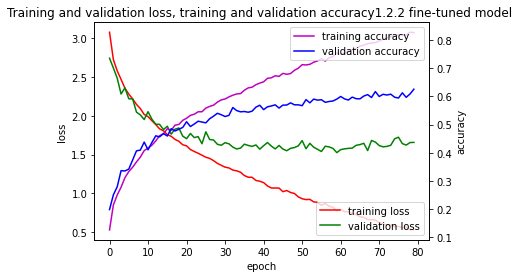

In [18]:
viz_model('results/FinecompletedatasetmodelH80.pt', "1.2.2 fine-tuned model ")

In [178]:
loss_fn = nn.CrossEntropyLoss()
run_model(100,'results/FinecompletedatasetmodelHClass100.pt',0.009, train_loader, model_122h)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 0 training loss:  3.094 training accuracy:  12.5%  validation loss:  2.732 validation accuracy:  19.9%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 1 training loss:  2.705 training accuracy:  21.8%  validation loss:  2.566 validation accuracy:  25.7%


100%|██████████| 169/169 [00:28<00:00,  5.94it/s]


epoch: 2 training loss:  2.559 training accuracy:  26.4%  validation loss:  2.446 validation accuracy:  28.1%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 3 training loss:  2.487 training accuracy:  28.2%  validation loss:  2.312 validation accuracy:  33.6%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 4 training loss:  2.379 training accuracy:  30.5%  validation loss:  2.285 validation accuracy:  34.2%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 5 training loss:  2.315 training accuracy:  32.5%  validation loss:  2.227 validation accuracy:  36.7%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 6 training loss:  2.212 training accuracy:  34.8%  validation loss:  2.181 validation accuracy:  38.2%


100%|██████████| 169/169 [00:28<00:00,  5.84it/s]


epoch: 7 training loss:  2.151 training accuracy:  37.3%  validation loss:  2.120 validation accuracy:  38.2%


100%|██████████| 169/169 [00:30<00:00,  5.59it/s]


epoch: 8 training loss:  2.068 training accuracy:  39.4%  validation loss:  2.086 validation accuracy:  38.9%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 9 training loss:  2.021 training accuracy:  40.8%  validation loss:  2.047 validation accuracy:  41.4%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 10 training loss:  1.987 training accuracy:  41.8%  validation loss:  1.909 validation accuracy:  44.4%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 11 training loss:  1.924 training accuracy:  43.6%  validation loss:  1.892 validation accuracy:  43.8%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 12 training loss:  1.886 training accuracy:  44.2%  validation loss:  1.923 validation accuracy:  44.3%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 13 training loss:  1.858 training accuracy:  44.7%  validation loss:  1.895 validation accuracy:  45.7%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 14 training loss:  1.807 training accuracy:  45.9%  validation loss:  1.893 validation accuracy:  47.0%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 15 training loss:  1.751 training accuracy:  48.3%  validation loss:  1.807 validation accuracy:  48.6%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 16 training loss:  1.730 training accuracy:  48.8%  validation loss:  1.830 validation accuracy:  47.4%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 17 training loss:  1.679 training accuracy:  50.2%  validation loss:  1.822 validation accuracy:  48.0%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 18 training loss:  1.646 training accuracy:  51.1%  validation loss:  1.720 validation accuracy:  50.7%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 19 training loss:  1.629 training accuracy:  51.7%  validation loss:  1.809 validation accuracy:  49.5%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 20 training loss:  1.604 training accuracy:  52.0%  validation loss:  1.801 validation accuracy:  50.2%


100%|██████████| 169/169 [00:28<00:00,  6.03it/s]


epoch: 21 training loss:  1.577 training accuracy:  52.8%  validation loss:  1.786 validation accuracy:  49.9%


100%|██████████| 169/169 [00:30<00:00,  5.57it/s]


epoch: 22 training loss:  1.537 training accuracy:  53.7%  validation loss:  1.680 validation accuracy:  50.3%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 23 training loss:  1.518 training accuracy:  53.9%  validation loss:  1.740 validation accuracy:  50.1%


100%|██████████| 169/169 [00:28<00:00,  5.94it/s]


epoch: 24 training loss:  1.478 training accuracy:  55.5%  validation loss:  1.710 validation accuracy:  50.9%


100%|██████████| 169/169 [00:29<00:00,  5.65it/s]


epoch: 25 training loss:  1.465 training accuracy:  55.6%  validation loss:  1.671 validation accuracy:  53.6%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 26 training loss:  1.433 training accuracy:  56.8%  validation loss:  1.679 validation accuracy:  52.5%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 27 training loss:  1.414 training accuracy:  57.1%  validation loss:  1.747 validation accuracy:  51.0%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 28 training loss:  1.371 training accuracy:  57.9%  validation loss:  1.671 validation accuracy:  54.2%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 29 training loss:  1.368 training accuracy:  58.6%  validation loss:  1.660 validation accuracy:  54.4%


100%|██████████| 169/169 [00:28<00:00,  5.90it/s]


epoch: 30 training loss:  1.340 training accuracy:  59.5%  validation loss:  1.690 validation accuracy:  53.3%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 31 training loss:  1.318 training accuracy:  59.6%  validation loss:  1.667 validation accuracy:  53.9%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 32 training loss:  1.279 training accuracy:  61.3%  validation loss:  1.643 validation accuracy:  54.9%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 33 training loss:  1.283 training accuracy:  60.8%  validation loss:  1.656 validation accuracy:  54.9%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 34 training loss:  1.255 training accuracy:  61.6%  validation loss:  1.641 validation accuracy:  55.6%


100%|██████████| 169/169 [00:28<00:00,  5.91it/s]


epoch: 35 training loss:  1.236 training accuracy:  62.0%  validation loss:  1.617 validation accuracy:  52.7%


100%|██████████| 169/169 [00:29<00:00,  5.81it/s]


epoch: 36 training loss:  1.212 training accuracy:  62.5%  validation loss:  1.627 validation accuracy:  55.7%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 37 training loss:  1.206 training accuracy:  63.5%  validation loss:  1.603 validation accuracy:  55.0%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 38 training loss:  1.165 training accuracy:  64.6%  validation loss:  1.567 validation accuracy:  55.0%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 39 training loss:  1.155 training accuracy:  64.2%  validation loss:  1.684 validation accuracy:  53.1%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 40 training loss:  1.135 training accuracy:  65.5%  validation loss:  1.680 validation accuracy:  55.4%


100%|██████████| 169/169 [00:28<00:00,  5.92it/s]


epoch: 41 training loss:  1.128 training accuracy:  65.0%  validation loss:  1.608 validation accuracy:  55.7%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 42 training loss:  1.089 training accuracy:  66.2%  validation loss:  1.612 validation accuracy:  56.2%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 43 training loss:  1.078 training accuracy:  66.4%  validation loss:  1.569 validation accuracy:  56.6%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 44 training loss:  1.044 training accuracy:  67.2%  validation loss:  1.667 validation accuracy:  55.8%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 45 training loss:  1.042 training accuracy:  68.1%  validation loss:  1.629 validation accuracy:  56.5%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 46 training loss:  1.014 training accuracy:  68.0%  validation loss:  1.570 validation accuracy:  57.0%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 47 training loss:  0.995 training accuracy:  69.0%  validation loss:  1.624 validation accuracy:  56.6%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 48 training loss:  0.983 training accuracy:  69.5%  validation loss:  1.564 validation accuracy:  58.9%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 49 training loss:  0.965 training accuracy:  69.8%  validation loss:  1.614 validation accuracy:  57.0%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 50 training loss:  0.949 training accuracy:  70.3%  validation loss:  1.553 validation accuracy:  58.7%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 51 training loss:  0.920 training accuracy:  71.4%  validation loss:  1.581 validation accuracy:  57.7%


100%|██████████| 169/169 [00:28<00:00,  5.95it/s]


epoch: 52 training loss:  0.910 training accuracy:  71.1%  validation loss:  1.577 validation accuracy:  59.1%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 53 training loss:  0.884 training accuracy:  72.1%  validation loss:  1.620 validation accuracy:  58.2%


100%|██████████| 169/169 [00:28<00:00,  5.95it/s]


epoch: 54 training loss:  0.873 training accuracy:  72.8%  validation loss:  1.591 validation accuracy:  58.0%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 55 training loss:  0.856 training accuracy:  72.8%  validation loss:  1.633 validation accuracy:  57.9%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 56 training loss:  0.846 training accuracy:  73.2%  validation loss:  1.636 validation accuracy:  58.3%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 57 training loss:  0.835 training accuracy:  73.5%  validation loss:  1.636 validation accuracy:  58.0%


100%|██████████| 169/169 [00:33<00:00,  4.99it/s]


epoch: 58 training loss:  0.798 training accuracy:  74.6%  validation loss:  1.590 validation accuracy:  58.0%


100%|██████████| 169/169 [00:35<00:00,  4.83it/s]


epoch: 59 training loss:  0.779 training accuracy:  75.0%  validation loss:  1.718 validation accuracy:  57.2%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 60 training loss:  0.784 training accuracy:  75.0%  validation loss:  1.556 validation accuracy:  59.1%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 61 training loss:  0.772 training accuracy:  75.2%  validation loss:  1.570 validation accuracy:  60.0%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 62 training loss:  0.756 training accuracy:  75.7%  validation loss:  1.648 validation accuracy:  59.2%


100%|██████████| 169/169 [00:29<00:00,  5.82it/s]


epoch: 63 training loss:  0.729 training accuracy:  76.8%  validation loss:  1.576 validation accuracy:  58.1%


100%|██████████| 169/169 [00:30<00:00,  5.63it/s]


epoch: 64 training loss:  0.706 training accuracy:  77.5%  validation loss:  1.649 validation accuracy:  58.8%


100%|██████████| 169/169 [00:28<00:00,  5.95it/s]


epoch: 65 training loss:  0.687 training accuracy:  78.4%  validation loss:  1.650 validation accuracy:  58.9%


100%|██████████| 169/169 [00:28<00:00,  5.94it/s]


epoch: 66 training loss:  0.677 training accuracy:  78.5%  validation loss:  1.620 validation accuracy:  59.5%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 67 training loss:  0.673 training accuracy:  78.6%  validation loss:  1.721 validation accuracy:  58.3%


100%|██████████| 169/169 [00:28<00:00,  5.85it/s]


epoch: 68 training loss:  0.652 training accuracy:  79.1%  validation loss:  1.656 validation accuracy:  59.4%


100%|██████████| 169/169 [00:29<00:00,  5.81it/s]


epoch: 69 training loss:  0.632 training accuracy:  79.8%  validation loss:  1.653 validation accuracy:  58.9%


100%|██████████| 169/169 [00:28<00:00,  5.91it/s]


epoch: 70 training loss:  0.621 training accuracy:  79.6%  validation loss:  1.655 validation accuracy:  58.9%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 71 training loss:  0.633 training accuracy:  79.5%  validation loss:  1.630 validation accuracy:  60.0%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 72 training loss:  0.591 training accuracy:  81.4%  validation loss:  1.715 validation accuracy:  58.7%


100%|██████████| 169/169 [00:28<00:00,  5.92it/s]


epoch: 73 training loss:  0.585 training accuracy:  81.0%  validation loss:  1.647 validation accuracy:  58.6%


100%|██████████| 169/169 [00:28<00:00,  5.94it/s]


epoch: 74 training loss:  0.591 training accuracy:  81.2%  validation loss:  1.740 validation accuracy:  60.0%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 75 training loss:  0.546 training accuracy:  83.0%  validation loss:  1.781 validation accuracy:  58.7%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 76 training loss:  0.565 training accuracy:  81.7%  validation loss:  1.645 validation accuracy:  60.3%


100%|██████████| 169/169 [00:28<00:00,  5.95it/s]


epoch: 77 training loss:  0.550 training accuracy:  82.2%  validation loss:  1.692 validation accuracy:  60.1%


100%|██████████| 169/169 [00:28<00:00,  5.92it/s]


epoch: 78 training loss:  0.519 training accuracy:  83.0%  validation loss:  1.757 validation accuracy:  59.9%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 79 training loss:  0.519 training accuracy:  83.5%  validation loss:  1.651 validation accuracy:  60.4%


100%|██████████| 169/169 [00:28<00:00,  5.91it/s]


epoch: 80 training loss:  0.499 training accuracy:  83.9%  validation loss:  1.755 validation accuracy:  60.7%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 81 training loss:  0.496 training accuracy:  83.9%  validation loss:  1.598 validation accuracy:  62.5%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 82 training loss:  0.482 training accuracy:  84.2%  validation loss:  1.889 validation accuracy:  59.9%


100%|██████████| 169/169 [00:28<00:00,  5.95it/s]


epoch: 83 training loss:  0.470 training accuracy:  84.8%  validation loss:  1.675 validation accuracy:  60.6%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 84 training loss:  0.447 training accuracy:  85.4%  validation loss:  1.771 validation accuracy:  60.9%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 85 training loss:  0.464 training accuracy:  84.9%  validation loss:  1.681 validation accuracy:  61.6%


100%|██████████| 169/169 [00:28<00:00,  5.90it/s]


epoch: 86 training loss:  0.436 training accuracy:  85.7%  validation loss:  1.707 validation accuracy:  60.8%


100%|██████████| 169/169 [00:28<00:00,  5.95it/s]


epoch: 87 training loss:  0.424 training accuracy:  86.4%  validation loss:  1.785 validation accuracy:  60.3%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 88 training loss:  0.406 training accuracy:  86.4%  validation loss:  1.847 validation accuracy:  59.7%


100%|██████████| 169/169 [00:28<00:00,  5.93it/s]


epoch: 89 training loss:  0.397 training accuracy:  87.3%  validation loss:  1.760 validation accuracy:  60.9%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 90 training loss:  0.390 training accuracy:  87.3%  validation loss:  1.805 validation accuracy:  60.9%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 91 training loss:  0.410 training accuracy:  86.4%  validation loss:  1.731 validation accuracy:  61.1%


100%|██████████| 169/169 [00:28<00:00,  5.88it/s]


epoch: 92 training loss:  0.410 training accuracy:  86.8%  validation loss:  1.729 validation accuracy:  60.8%


100%|██████████| 169/169 [00:28<00:00,  5.93it/s]


epoch: 93 training loss:  0.378 training accuracy:  88.3%  validation loss:  1.741 validation accuracy:  61.0%


100%|██████████| 169/169 [00:28<00:00,  5.95it/s]


epoch: 94 training loss:  0.354 training accuracy:  88.2%  validation loss:  1.746 validation accuracy:  61.0%


100%|██████████| 169/169 [00:28<00:00,  5.90it/s]


epoch: 95 training loss:  0.366 training accuracy:  88.0%  validation loss:  1.711 validation accuracy:  61.6%


100%|██████████| 169/169 [00:28<00:00,  5.93it/s]


epoch: 96 training loss:  0.353 training accuracy:  88.4%  validation loss:  1.845 validation accuracy:  60.6%


100%|██████████| 169/169 [00:28<00:00,  5.91it/s]


epoch: 97 training loss:  0.327 training accuracy:  89.5%  validation loss:  1.716 validation accuracy:  61.8%


100%|██████████| 169/169 [00:28<00:00,  5.94it/s]


epoch: 98 training loss:  0.330 training accuracy:  89.4%  validation loss:  1.854 validation accuracy:  60.6%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 99 training loss:  0.325 training accuracy:  89.6%  validation loss:  1.812 validation accuracy:  60.4%


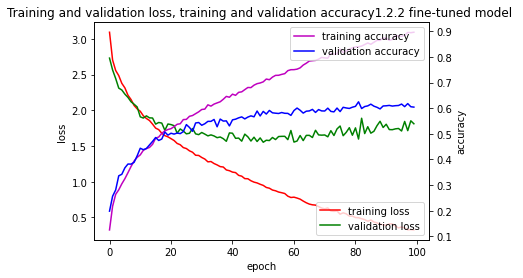

In [179]:
viz_model('results/FinecompletedatasetmodelHClass100.pt', "1.2.2 fine-tuned model ")


### 1.2.3 Training comparison [4 marks]

Display, side-by-side or on one single graph, the training and validation loss graphs for the single-batch training (section 1.1.3), on the full training set (1.2.1) and your final fine-tuned model (1.2.2). 

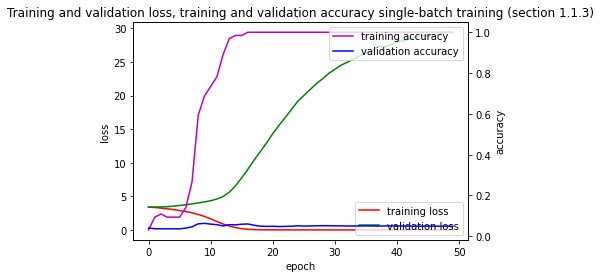

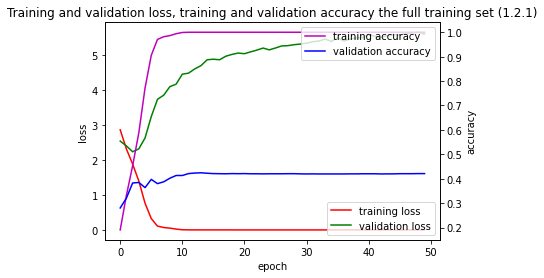

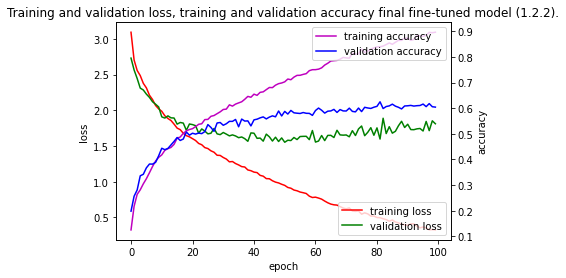

In [15]:
#single batch
viz_model('results/singlebatch50epochsClass.pt', " single-batch training (section 1.1.3)")
#full training 
viz_model('results/completedataset50epochsClass.pt'," the full training set (1.2.1)" )
#fine-tuned
viz_model('results/FinecompletedatasetmodelHClass100.pt', " final fine-tuned model (1.2.2).")


Explain what can be seen in the graphs.

Overall, it is clear that the best model architecture is the finetuning model since the loss in both sets decreases and the accuracy increases. This is due to adding data augmentation which increases the number of the relevant data and helps the model distinguish between the different classes and learn the relevant patterns, and adding dropout to prevent overfitting, and adding the batch normalization to reduce the variability of training data. On the other hand, it is entirely the opposite in the first two graphs because the model has wide and shallow neural networks which cause overfitting over the training set. Therefore, the generalization is low in the model since there is a large gap between the loss of the training and validation sets 


### 1.2.4 Confusion matrices [7 marks]

Use your architecture with best accuracy to generate two confusion matrices, one for the training set and one for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.



In [153]:
categories_names=(pd.read_csv(mapping_img30,header=None,sep="\t")).drop(columns=[2])
categories_names=categories_names[1]
categories_names = categories_names.tolist()

In [180]:
def accuracy(cnfm):
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)  

In [195]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def get_all_pred(model,loader,categories_names):
    all_preds=torch.tensor([])
    all_labels=torch.tensor([])
    i=0
    with torch.no_grad():
        for batch in tqdm(loader):
            images,label=batch
            preds=model(images.to(device=device))
            
            all_preds=torch.cat((all_preds.to(device=device),preds.to(device=device)),dim=0)
            all_labels=torch.cat((all_labels.to(device=device),label.to(device=device)),dim=0)
            
        fig, ax = plt.subplots(figsize=(25,25))
        cm=confusion_matrix(all_labels.tolist(),all_preds.argmax(dim=1).tolist())
        conf_matrix=pd.DataFrame(data=cm,columns=categories_names
                                          ,index=categories_names)
        #sns.heatmap(conf_matrix, annot=True, fmt="d")
        ax = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Greens')
        ax.set_title('Confusion Matrix with labels\n\n');
        ax.set_xlabel('\nPredicted Images')
        ax.set_ylabel('Actual Images ');
        
        plt.show()

        # show per-class recall and precision
        print(f"Accuracy: {accuracy(cm) :.1%}")
        r = recalls(cm)
        p = precisions(cm)
        for i in range(len(categories_names)):
            print(f"Class {categories_names[i]} : Precision {p[i] :.1%}  Recall {r[i] :.1%}")

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:26<00:00,  6.30it/s]


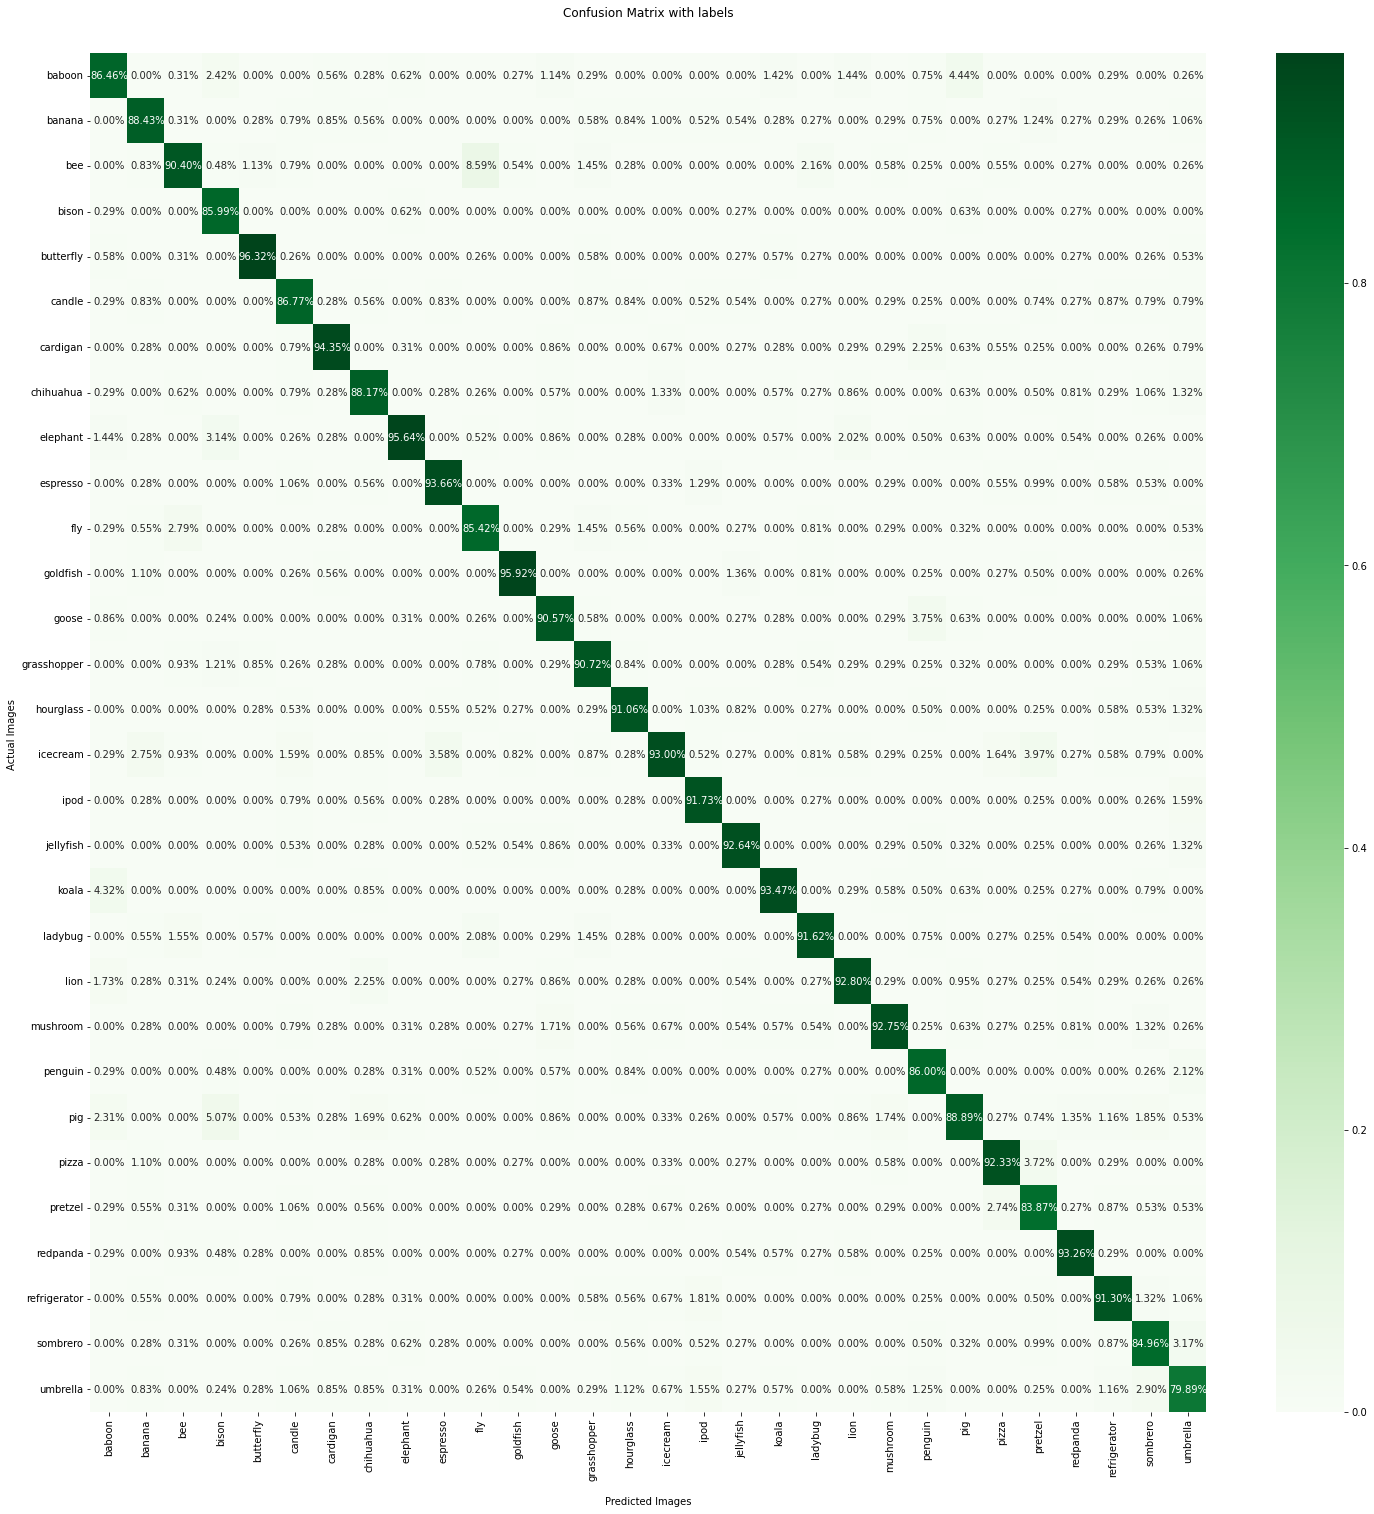

Accuracy: 90.1%
Class baboon : Precision 86.5%  Recall 85.5%
Class banana : Precision 88.4%  Recall 88.7%
Class bee : Precision 90.4%  Recall 81.1%
Class bison : Precision 86.0%  Recall 98.1%
Class butterfly : Precision 96.3%  Recall 95.8%
Class candle : Precision 86.8%  Recall 90.1%
Class cardigan : Precision 94.4%  Recall 91.3%
Class chihuahua : Precision 88.2%  Recall 89.2%
Class elephant : Precision 95.6%  Recall 87.7%
Class espresso : Precision 93.7%  Recall 93.4%
Class fly : Precision 85.4%  Recall 91.9%
Class goldfish : Precision 95.9%  Recall 94.6%
Class goose : Precision 90.6%  Recall 90.8%
Class grasshopper : Precision 90.7%  Recall 90.2%
Class hourglass : Precision 91.1%  Recall 91.8%
Class icecream : Precision 93.0%  Recall 77.5%
Class ipod : Precision 91.7%  Recall 95.4%
Class jellyfish : Precision 92.6%  Recall 93.9%
Class koala : Precision 93.5%  Recall 91.4%
Class ladybug : Precision 91.6%  Recall 91.6%
Class lion : Precision 92.8%  Recall 89.9%
Class mushroom : Precisi

In [196]:
get_all_pred(model_122h,train_loader,categories_names)

  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


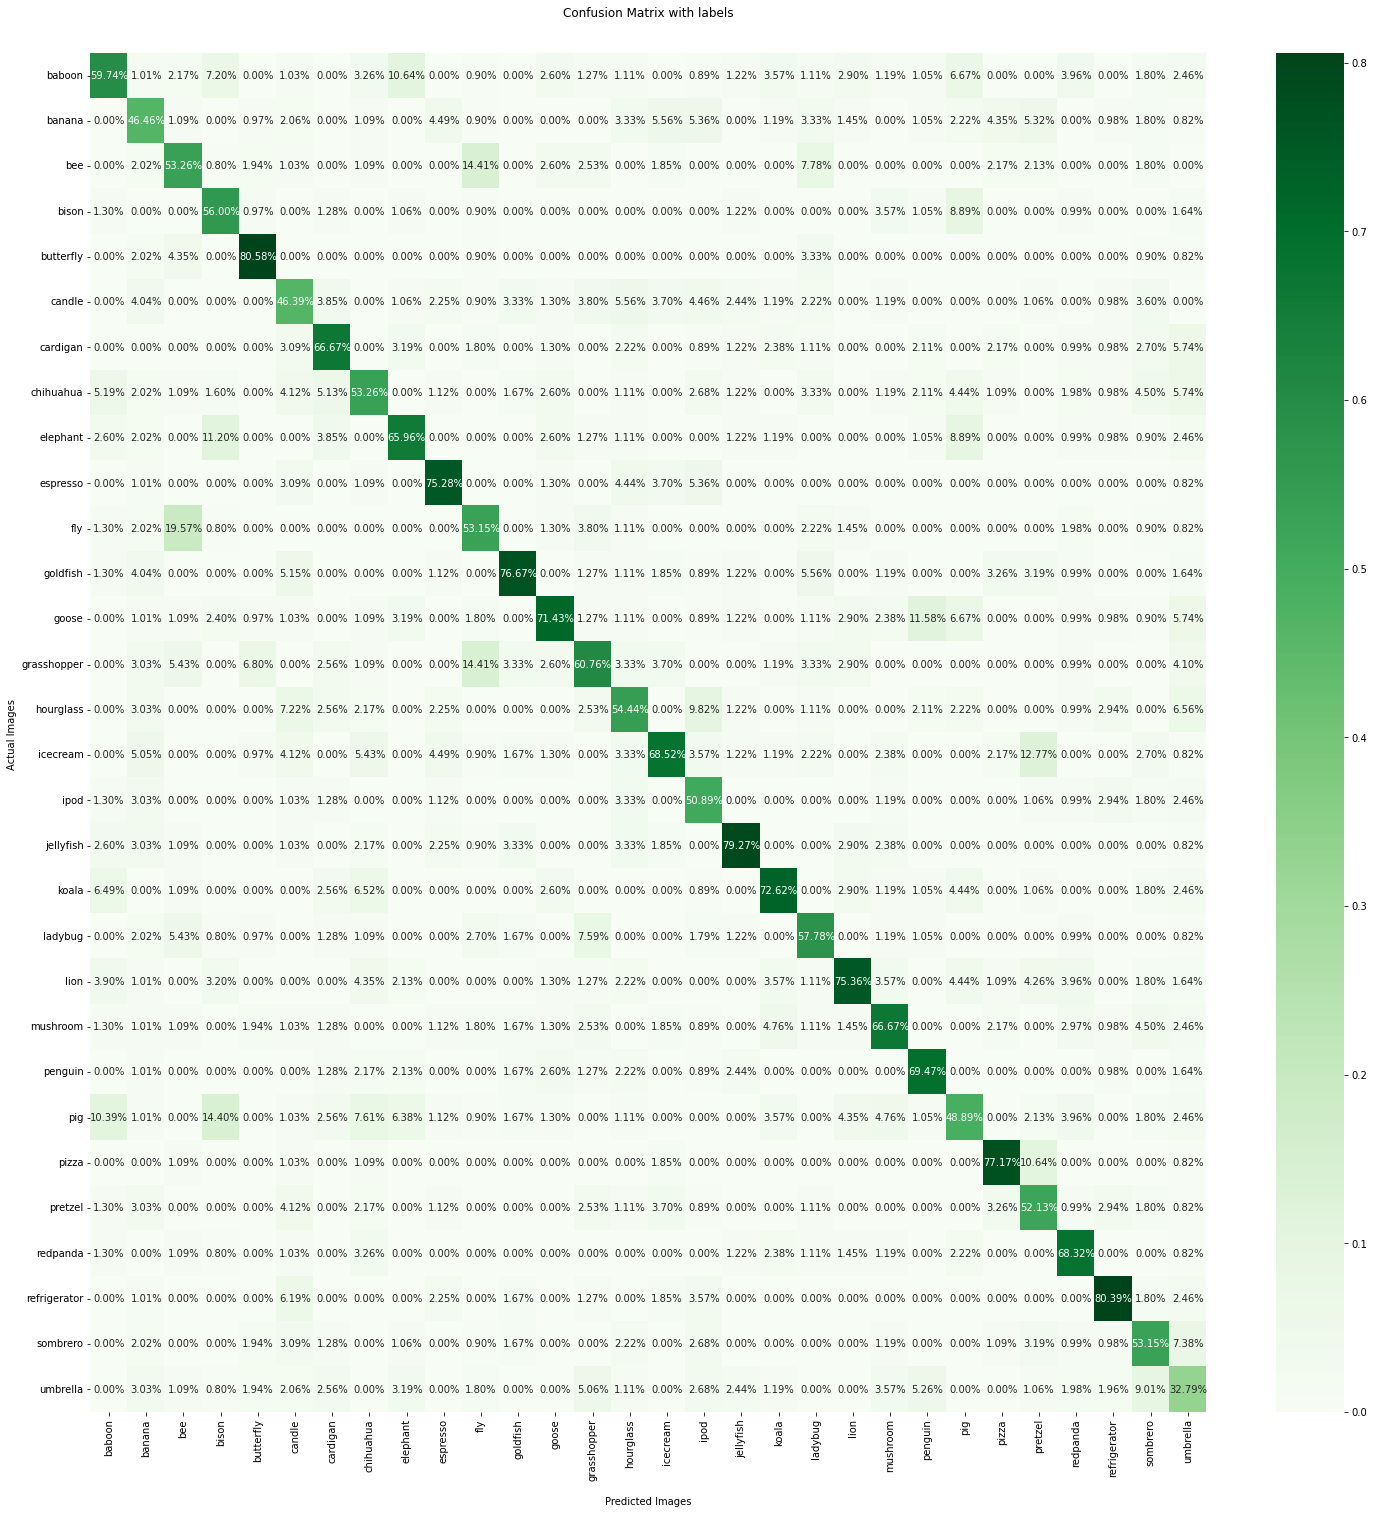

Accuracy: 61.6%
Class baboon : Precision 59.7%  Recall 46.5%
Class banana : Precision 46.5%  Recall 52.3%
Class bee : Precision 53.3%  Recall 54.4%
Class bison : Precision 56.0%  Recall 80.5%
Class butterfly : Precision 80.6%  Recall 87.4%
Class candle : Precision 46.4%  Recall 52.3%
Class cardigan : Precision 66.7%  Recall 61.9%
Class chihuahua : Precision 53.3%  Recall 49.5%
Class elephant : Precision 66.0%  Recall 62.0%
Class espresso : Precision 75.3%  Recall 77.9%
Class fly : Precision 53.2%  Recall 63.4%
Class goldfish : Precision 76.7%  Recall 59.7%
Class goose : Precision 71.4%  Recall 54.5%
Class grasshopper : Precision 60.8%  Recall 46.6%
Class hourglass : Precision 54.4%  Recall 51.6%
Class icecream : Precision 68.5%  Recall 41.1%
Class ipod : Precision 50.9%  Recall 73.1%
Class jellyfish : Precision 79.3%  Recall 73.9%
Class koala : Precision 72.6%  Recall 67.8%
Class ladybug : Precision 57.8%  Recall 65.0%
Class lion : Precision 75.4%  Recall 56.5%
Class mushroom : Precisi

In [197]:
get_all_pred(model_122h,valid_loader,categories_names)

What conclusions can be drawn from the confusion matrices?

The confusion matrices show that the model performs well in the training and validation sets because the class's precision along the diagonal demonstrates a relatively high percentage. Although the precision of the validation set decreases for all the classes compared to the training set, the precision is still good. For instance, the precision of ‘butterfly' is approximately 96% in the test set, but in the validation set the precision is almost 80% which is good as well.



## 1.3 Testing on test data [18 marks]

### 1.3.1 Dataset and generating predictions [6 marks]

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. 


In [184]:
test_dir = ROOT + "test_set/test_set"
img_paths= []
img_name= []

for entry in os.scandir(test_dir):
    if (entry.is_file()):
        img_paths.append(entry.path)
        img_name.append(entry.name)
            
data = {'path': img_paths,'class': 0}

test_df = pd.DataFrame(data, columns=['path','class'])


print("length of test images = ", len(test_df), "image")
print(test_df.head())

transfrm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
test_dataset = TinyImageNet30(
    df=test_df,
    transform=transfrm,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

length of test images =  1500 image
                                                path  class
0  /content/drive/MyDrive/comp5623m-2022/test_set...      0
1  /content/drive/MyDrive/comp5623m-2022/test_set...      0
2  /content/drive/MyDrive/comp5623m-2022/test_set...      0
3  /content/drive/MyDrive/comp5623m-2022/test_set...      0
4  /content/drive/MyDrive/comp5623m-2022/test_set...      0


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in 

torch.Size([64, 3, 64, 64])


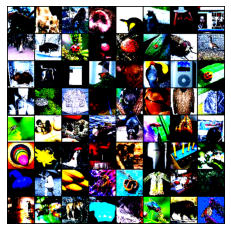

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [185]:

dataiter = iter(test_loader)
images, labels = dataiter.next()

print(images.size())

timshow(utils.make_grid(images))
print(*labels.numpy())  

In [186]:
predicted_class = []
for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward, backward, and update parameters
        outputs = model_122h(inputs)
        
        # the predicted lables / classes
        _, predicted = torch.max(outputs.data, 1)
        #add the predicted lables to the list
        predicted_class.extend(predicted.tolist()) 


### 1.3.2 CSV file and test set accuracy [12 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers.

> You may submit multiple times. We will use your personal top entry for allocating marks for this [10 marks]. The class leaderboard will not affect marking (brownie points!).



In [ ]:
# TO COMPLETE

In [187]:
data = {'ID': img_name,'Category': predicted_class}

In [188]:
test_df =pd.DataFrame(data,columns=['ID','Category'])

print("test length", len(data_df))
test_df.head()

test length 13500


,ID,Category
0,7f19ba4a_9471.JPEG,26
1,ff1e4f2b_5114.JPEG,20
2,b31f291a_7c51.JPEG,18
3,bb79ae30_cb47.JPEG,0
4,76978129_c38e.JPEG,22


In [189]:
test_df.to_csv("ml20baya.csv", index= False, header=True)

In [190]:
!cp ml20baya.csv "/content/drive/MyDrive/comp5623m-2022"



## QUESTION 2 [40 marks]



In this question, you will visualize the filters and feature maps of a fully-trained CNN (AlexNet) on the full ImageNet 2012 dataset.

> Please do not alter the name of the function or the number and type of its arguments and return values, otherwise the automatic grading function will not work correctly. You are welcome to import other modules (though the simplest solution only requires the ones below).


### **Overview:**
*   **2.1.1** Extract filters from model: ``fetch_filters(layer_idx, model)``
*   **2.2.1** Load test image
*   **2.2.2** Extract feature maps for given test image: ``fetch_feature_maps(image, model)``
*   **2.2.3** Display feature maps
*   **2.3.1** Generate Grad-CAM heatmaps: ``generate_heatmap(output, class_id, model, image)``
*   **2.3.2** Display heatmaps: add code to cell
*   **2.3.3** Generate heatmaps for failure analysis


### Loading a pre-trained model

Run the cell below to load an AlexNet model with pre-trained weights.

In [3]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [5]:
model.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [6]:
model.features[0].weight.shape

torch.Size([64, 3, 11, 11])


## 2.1 Extract and visualize the filters [6 marks]

In this section you will extract and visualize the filters from the pre-trained AlexNet.

### 2.1.1 Extract filters [4 marks]

Complete the following function ```fetch_filters``` to return all the filters from the convolutional layers at the given index in ```model.features``` (see printed model above for reference). 





> We will not test the behaviour of your function using invalid indices.



In [7]:
def fetch_filters(layer_idx, model):
    """ 
        Args:
            layer_idx (int): the index of model.features specifying which conv layer
            model (AlexNet): PyTorch AlexNet object
        Return:
            filters (Tensor):      
    """
    filters = model.features[layer_idx].weight.detach()
    # TO COMPLETE
    return filters

In [8]:
# all the indices of the conv layers
conv_layer_idx = [0, 3, 6, 8, 10]

filters = []

for layer_idx in conv_layer_idx:
    filters.append(fetch_filters(layer_idx, model))

For your testing purposes, the following code blocks test the dimensions of the function output.

In [9]:
filters[0].shape

torch.Size([64, 3, 11, 11])

In [10]:
assert list(filters[0].shape) == [64, 3, 11, 11]



### 2.1.2 Display filters [2 marks]

The following code will visualize some of the filters from each layer. Play around with viewing filters at different depths into the network. Note that ```filters[0]``` could be viewed in colour if you prefer, whereas the subsequent layers must be viewed one channel at a time in grayscale. 



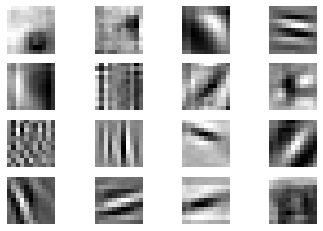

In [11]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(filters[0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="gray")
    plt.axis('off')
plt.show()



## 2.2 Extract and visualize feature maps [10 marks]

In this section, you will pass a test image through the AlexNet and extract and visualize the resulting convolutional layer feature maps.

Complete the following code cell to load the test image ```man_bike.JPEG```.



### 2.2.1 Load test image [1 mark]


In [42]:
# TO COMPLETE
from PIL import Image

im = Image.open('/content/drive/MyDrive/comp5623m-2022/man_bike.JPEG')
im = im.convert('RGB')

Run the code cell below to apply the image transformation expected by the model.

In [43]:
# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im = data_transform(im)


### 2.2.2 Extract feature maps [5 marks]

Complete the function below to pass the test image through a single forward pass of the network. We are interested in the outputs of the max pool layers (outputs of conv layers at model.features indices 0, 3, and 10) for best visualization. Note that the input should pass through *every layer* of the model.

In [44]:
def fetch_feature_maps(image, model):
    """
    Args:
        image (Tensor): a single input image with transform applied
        model (AlexNet): PyTorch AlexNet object
        
    Return:
        feature_maps (Tensor): all the feature maps from conv layers 
                    at indices 0, 3, and 10 (outputs of the MaxPool layers)
    """
    
    
    max_pool_layer = [2,5,12]
    
    
    feature_maps = []
    model_length = len(model.features)
    for i in range(model_length):
        image = model.features[i].forward(image)
        # extract the feature map in the max pool layers
        if i in max_pool_layer:
            feature_map = image
            feature_maps.append(feature_map)


    return feature_maps

In [45]:
feature_maps = fetch_feature_maps(im.unsqueeze(0), model)

In [46]:
feature_maps[0][0].shape

torch.Size([64, 31, 31])

For your testing purposes, the following code block tests the dimensions of part of the function output. Note that the first dimension is the batch size.

In [47]:
assert len(feature_maps) == 3
assert list(feature_maps[0].shape) == [1, 64, 31, 31]



### 2.2.3 Display feature maps [4 marks]

Using the code for displaying filters as reference, write code in the block below to display the outputs of the first **16 feature maps from each of the 3 max-pool layers**.

max pool layer 0


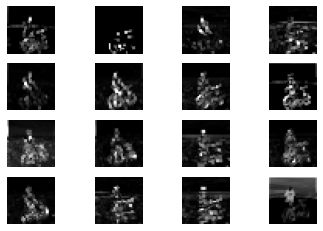

max pool layer 1


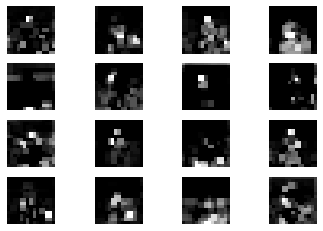

max pool layer 2


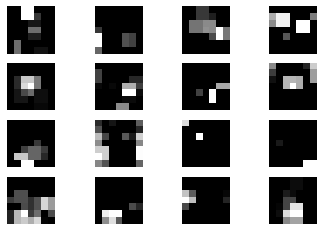

In [48]:
to_show = 16

plt_dim = int(math.sqrt(to_show))

for j in range(len(feature_maps)):
    print("max pool layer", j)
    for i, filt in enumerate(feature_maps[j][0].detach().numpy()[:to_show]):
        plt.subplot(plt_dim, plt_dim, i+1)
        plt.imshow(filt, cmap="gray")
        plt.axis('off')
    plt.show()




## 2.3 Understanding of filters and feature maps [7 marks]

Respond in detail to the questions below. (Note that all text boxes can be formatted using Markdown if desired).

### 2.3.1 [3 marks]
Describe what the three filters at indices 0, 4, and 6 from the first convolutional layer are detecting (reference the corresponding feature maps to support your discussion).


The following filters used in the first convolutional layer to detect specific features, and question 2.1.1 displaied their feature maps:
Filter 0 detects the circles, so its feature map represents the head

Filter 4 its feature map shows the arm

Filter 6 detects the diagonal line and its features map displays the edges of the bicycle and the body shape.



### 2.3.2 [2 marks]


Discuss how the filters change with depth into the network.

The filters in the higher layers of the network focus on the larger structures and the broad features such as people, dogs. As the filters go down to the lower layers, they gradually detect specific details relevant to the image classification.

### 2.3.3 [2 marks]
Discuss how the feature maps change with depth into the network.

Each feature map is a representation of what the filter windows detect when move over an image, so the feature map is going to represent the important features in brighter colours. As in the filters, the feature maps also represent more detailed and complex features when it goes deeper in the network.


## 2.4 Gradient-weighted Class Activation Mapping (Grad-CAM) [17 marks]

In this section, we will explore using Gradient-weighted Class Activation Mapping (Grad-CAM) to generate coarse localization maps highlighting the important regions in the test images guiding the model's prediction. We will continue using the pre-trained AlexNet.

#### Preparation
>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.

#### The AlexNet class

>To implement Grad-CAM, we need to edit the AlexNet ```module``` class itself, so instead of loading the AlexNet model from ```torch.hub``` as we did above, we will use the official PyTorch AlexNet class code ([taken from here](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)). In addition to the class definition, there is also a function below called ```alexnet()``` which allows you to specify whether you want the pretrained version or not, and if so, loads the weights. 

#### The hook

>[Hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) in PyTorch are functions which can be registered, or attached, to a ```Module``` or ```Tensor```. Hooks can be *forward* hooks or *backward* hooks; forward hooks are called with ```forward()``` and backward hooks with ```backward()```. In the model below, we register a forward hook that saves the **gradients of the activations** to the Tensor output of ```model.features```. The gradients are saved to a class variable so we can easily access them.

Carefully read the code block below. You do not need to add anything to the model.

In [49]:
# defining where to load the pre-trained weights from
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}

# the class definition
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # a placeholder for storing the gradients
        self.gradients = None
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    # the hook for the gradients of the activations
    def activations_hook(self, grad):
        # stores the gradients of the hook's tensor to our placeholder variable
        self.gradients = grad

    # a method for extracting the activations of the last conv layer only (when we're 
    # not interested in a full forward pass)
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        # we register the hook here to save the gradients of the last convolutional
        # layer outputs
        hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [50]:
model = alexnet(pretrained=True)

In [51]:
# pass our test image through our new model with the hook
output = model(im.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)

Examine and understand the values stored in ```output``` and ```pred_cls```. What does AlexNet classify the test image as?

In [ ]:
output

In [52]:
pred_cls

tensor([[671]])

In [32]:
mapping = pd.read_table('/content/drive/MyDrive/comp5623m-2022/alexaNet_mapping/imagenet1000_clsidx_to_labels.txt', header = None)

In [53]:
mapping.iloc[int(pred_cls)]

0     671: 'mountain bike, all-terrain bike, off-ro...
Name: 671, dtype: object

### 2.4.1 Generate Grad-CAM heatmaps [8 marks]

With the hooks in place, now implement the code to generate Grad-CAM heatmaps, by following the guiding comments in the code block below.

In [54]:
def generate_heatmap(output, class_id, model, image):
    
    # 1. compute the gradient of the score for the predicted class (logit)
    # with respect to the feature map activations of the last convolutional layer
    # Hint: calling .backward() on a Tensor computes its gradients
    # TO COMPLETE
    output[:,class_id].backward()
    
    
    # 2. get the gradients from the model placeholder variable
    # TO COMPLETE
    gradients = model.gradients
    assert list(gradients.shape) == [1, 256, 7, 7]
    
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    assert list(pooled_gradients.shape) == [256]
    
    # 3. get the activations of the last convolutional layer
    # TO COMPLETE
    activations = model.get_activations(image).detach()
    assert list(activations.shape) == [1, 256, 7, 7]
    
    # 4. weight (multiply) the channels (dim=1 of activations) by the corresponding
    # gradients (pooled_gradients)
    # TO COMPLETE
    for i in range(256):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations and squeeze out the extra dimension
    
    heatmap = torch.mean(activations, dim=1).squeeze()
    
    assert list(heatmap.shape) == [7, 7]
    
    # 5. apply a ReLU to the linear combination of maps because we are only 
    # interested in the features that have a positive influence on the class of 
    # interest, i.e. pixels whose intensity should be increased in order to increase y
    # Hint: you can use np.maximum() and torch.max() to perform ReLU if you prefer.
    
    # TO COMPLETE
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap) 
    
    return heatmap

In [55]:
heatmap = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))

Check the dimensions of ```heatmap```. Do they make sense?

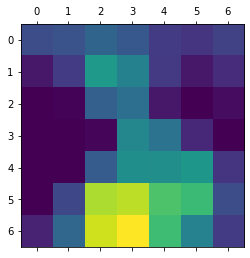

In [56]:
plt.matshow(heatmap)

In [57]:
heatmap.shape

torch.Size([7, 7])

### 2.4.2 Display heatmaps [4 marks]

Display ```heatmap``` as a coloured heatmap super-imposed onto the original image. To get results as shown in the paper, we recommend the following steps:

1. Resize the heatmap to match the size of the image.
2. Rescale the image to a 0-255 integer range.
3. Apply a colormap to the heatmap using ```cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)```.
4. Multiply all values of heatmap by 0.4 to reduce colour saturation.
5. Superimpose the heatmap onto the original image (Note: please perform cv2's addition - addition of two cv2 images, not numpy addition. See [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#:~:text=addWeighted()%20etc.-,Image%20Addition,OpenCV%20addition%20and%20Numpy%20addition.) for explanation.)
6. Normalize the image between 0-255 again.
7. Display the resulting image.

In [58]:
def display_heatmap(heatmap,image):
#1

  heatmap = cv2.resize(heatmap.numpy(), (image.shape[0], image.shape[1]))
  
#2 

  numer = heatmap - np.min(heatmap)
  denom = (heatmap.max() - heatmap.min()) + 1e-8
  heatmap_norm = numer / denom
  heatmap_norm = (heatmap_norm * 255).astype("uint8")
 
#3
  heatmap_norm = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
#4
  heatmap_norm=heatmap_norm * 0.4
#5
  #heatmap_normalized=heatmap_normalized.reshape((256,256,1))*np.ones([256,256,3])
  w_image= cv2.addWeighted(heatmap_norm, 0.7, image, 0.3, 0)
#6
  numer = w_image - np.min(w_image)
  denom = (w_image.max() - w_image.min()) + 1e-8
  final_image = numer / denom
  final_image = (final_image * 255).astype("uint8")

  return final_image

In [59]:
im_bike = cv2.imread('/content/drive/MyDrive/comp5623m-2022/man_bike.JPEG')
im_bike=cv2.resize(im_bike,(256,256))
im_bike = np.asarray(im_bike, np.float64)

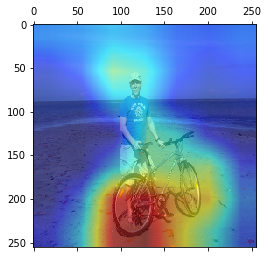

In [60]:
display=display_heatmap(heatmap,im_bike)
plt.matshow(display[:, :, ::-1])

Show the heatmap for class ```'seashore, coast, seacoast, sea-coast'``` (```class_id = 978```), super-imposed onto the original image.

In [61]:
output_978 = model(im.unsqueeze(0))

In [62]:
heatmap = generate_heatmap(output_978, torch.tensor(978), model, im.unsqueeze(0))
display=display_heatmap(heatmap,im_bike)

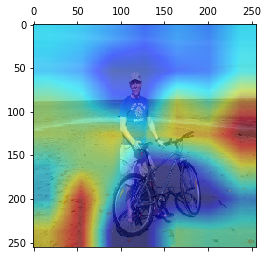

In [63]:
plt.matshow(display[:, :, ::-1])

### 2.4.3 Failure analysis using Grad-CAM [5 marks]

Find an image (online, or from ImageNet or another dataset) which AlexNet classifies *incorrectly*. Display the image below, and show the model's predicted class. Then, generate the Grad-CAM heatmap and display it super-imposed onto the image.

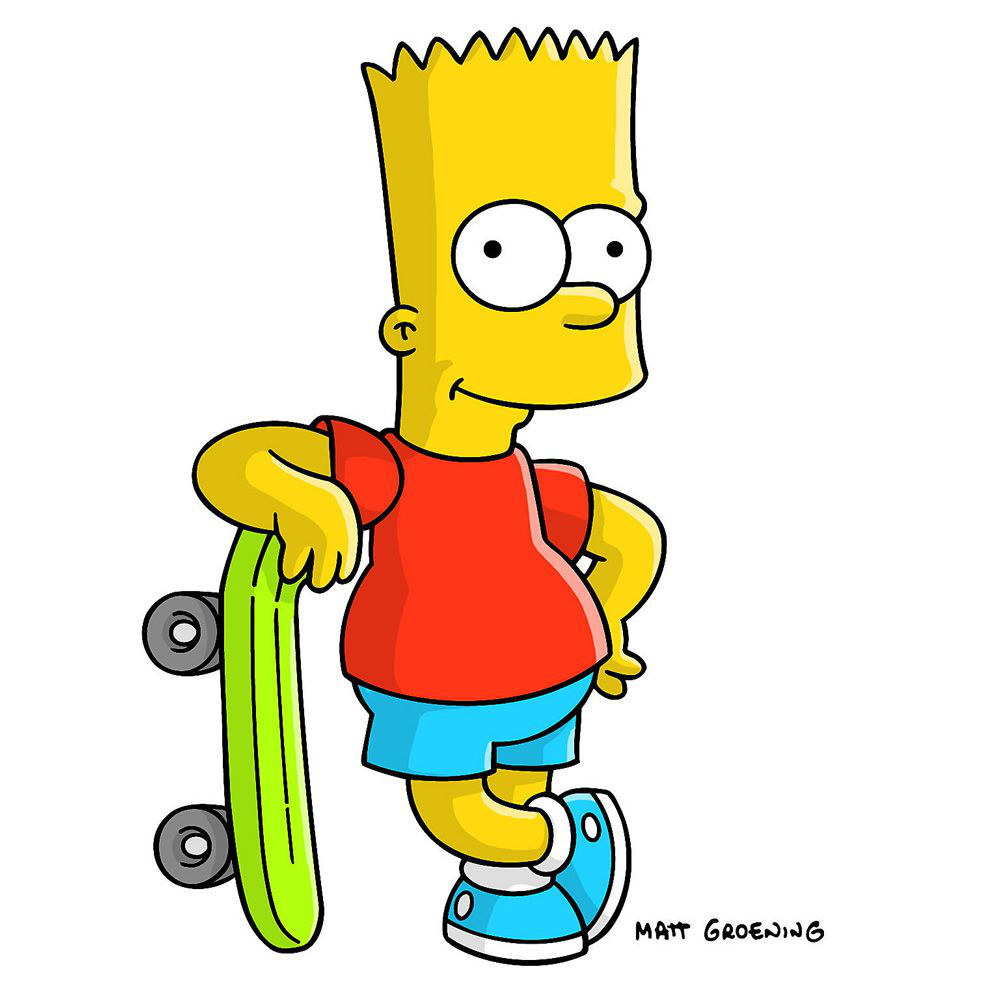

In [108]:
# TO COMPLETE
from PIL import Image

im_simpson = Image.open('/content/drive/MyDrive/comp5623m-2022/bart-simpson.jpg')
im_simpson = im_simpson.convert('RGB')
im_simpson

In [109]:
# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im_simpson = data_transform(im_simpson)

In [110]:
model = alexnet(pretrained=True)

In [111]:
# pass our test image through our new model with the hook
output = model(im_simpson.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)
pred_cls

tensor([[709]])

In [112]:
mapping.iloc[int(pred_cls)]

0     709: 'pencil box, pencil case',
Name: 709, dtype: object

In [113]:
heatmap_simpson = generate_heatmap(output, pred_cls, model, im_simpson.unsqueeze(0))

In [114]:
im_simpson = cv2.imread('/content/drive/MyDrive/comp5623m-2022/bart-simpson.jpg')
im_simpson=cv2.resize(im_simpson,(256,256))
im_simpson = np.asarray(im_simpson, np.float64)

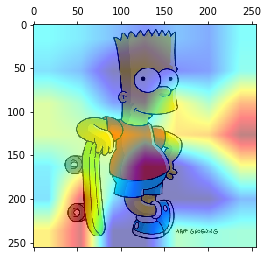

In [115]:
#heatmap
display=display_heatmap(heatmap,im_simpson)
plt.matshow(display[:, :, ::-1])

Briefly describe what explanation the Grad-CAM heatmap provides about why the model has failed to correctly classify your test image.

Alexnet is pre-trained on a set of specific images, therefore it has its unique set of filter values that are able to detect specific features based on the training dataset. Cartoon character image is not one of the images in the training set, which means Alexanet does not have the filter values to detect this test image and it classifies Bart Simpson's image as 'pencil box, pencil case' which is a wrong classification. 

### 3 Overall quality [2 marks]

Marks awarded for overall degree of code readibility and omission of unnecessary messy outupts (for example, please avoid printed losses for every batch of a long training process, large numpy arrays, etc.) throughout the work.

**Please refer to the submission section at the top of this notebook to prepare your submission.**
